In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D




/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

In [310]:
### Data loading and aggregating ========================

def get_fit_dpaths(dsets, fit_desc=None, excluded_sessions=[],
              rootdir='/n/coxfs01/2p-data'):
    '''
    rfdata: (dataframe)
        Metadata (subset of 'sdata') of all datasets to include in current analysis
        
    Gets paths to fit_results.pkl, which contains all (fit-able) results for each cell.
    Adds new column of paths to rfdata.
    '''
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = dsets.copy()
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '_'.join([animalid, session, fov])
        if skey in excluded_sessions:
            rfdata = rfdata.drop(g.index)
            continue

        rfruns = g['experiment'].unique()
        for rfname in rfruns:
            curr_rfname = 'gratings' if int(session) < 20190511 else rfname
            fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                        'combined_%s_*' % curr_rfname, 'traces', '%s*' % traceid, 
                                        'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "Too many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
            elif len(fpath) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                print("[%s] %s - warning: unknown file paths" % (skey, rfname))
    print("N dpaths: %i, N unfit: %i" % (len(dpaths), len(fit_these)))
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    
    rdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rdata[ (rdata['animalid']==animalid) \
                           & (rdata['session']==session) \
                           & (rdata['fov']==fov) \
                           & (rdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rdata['path'] = fillpaths
    rdata = rdata.drop_duplicates().reset_index(drop=True)
    
    return rdata, fit_these


def aggregate_rf_data(rf_dpaths, fit_thr=0.5, scale_size=True, sigma_scale=2.35, verbose=False,
                     rootdir='/n/coxfs01/2p-data'):
    '''
    Combines fit_results.pkl(fit from data) and evaluation_results.pkl (evaluated fits via bootstrap)
    and gets fit results only for those cells that are good/robust fits based on bootstrap analysis.
    '''
    df_list = []
    for (visual_area, animalid, session, fovnum, experiment), g in rf_dpaths.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'experiment']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum) #'-'.join([animalid, session, fovnum])

        #### Load evaluation results (bootstrap analysis of each fit paramater)
        curr_rfname = experiment if int(session)>=20190511 else 'gratings'
        eval_dpaths = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                             '*%s_*' % curr_rfname, 'traces', '%s*' % traceid, 
                                             'receptive_fields', fit_desc, 'evaluation', 'evaluation_results.pkl'))
        assert len(eval_dpaths)==1, "%s: Evaluation not found: %s" % (datakey, str(eval_dpaths))
        eval_dpath = eval_dpaths[0]
        with open(eval_dpath, 'rb') as f:
            eval_results = pkl.load(f)
        if eval_results is None:
            print('-- no good (%s), skipping' % datakey)
            continue

        #### Load fit results from measured
        fpath = g['path'].values[0]
        with open(fpath,'rb') as f:
            fit_results = pkl.load(f)
        fit_rois = sorted(eval_results['data']['cell'].unique())
        rfit_df = fitrf.rfits_to_df(fit_results['fit_results'], scale_size=True,
                                    row_vals=fit_results['row_vals'], 
                                    col_vals=fit_results['col_vals'], roi_list=fit_rois)
        
        #### Identify cells with measured params within 95% CI of bootstrap distN
        param_list = [param for param in rfit_df.columns if param != 'r2']
        pass_rois = get_good_fits(rfit_df, eval_results, param_list=param_list)
        if verbose:
            print("[%s] %s: %i of %i fit rois pass for all params" % (visual_area, datakey, len(pass_rois), len(fit_rois)))
            
        #### Create dataframe with params only for good fit cells
        passdf = rfit_df.loc[pass_rois].copy()
        # "un-scale" size, if flagged
        if not scale_size:
            sigma_x = passdf['sigma_x']/sigma_scale
            sigma_y = passdf['sigma_y'] / sigma_scale
            passdf['sigma_x'] = sigma_x
            passdf['sigma_y'] = sigma_y
            
        tmpmeta = pd.DataFrame({'cell': pass_rois,
                                'datakey': [datakey for _ in np.arange(0, len(pass_rois))],
                                'animalid': [animalid for _ in np.arange(0, len(pass_rois))],
                                'session': [session for _ in np.arange(0, len(pass_rois))],
                                'visual_area': [visual_area for _ in np.arange(0, len(pass_rois))],
                                'experiment': [experiment for _ in np.arange(0, len(pass_rois))]}, index=passdf.index)

        fitdf = pd.concat([passdf, tmpmeta], axis=1).reset_index(drop=True)
        df_list.append(fitdf)
    rfdf = pd.concat(df_list, axis=0) #.reset_index(drop=True)
    
    # Include average RF size (average of minor/major axes of fit ellipse)
    rfdf['avg_size'] = rfdf[['sigma_x', 'sigma_y']].mean(axis=1)

    return rfdf


def get_good_fits(rfit_df, eval_results, param_list=[]):
    '''
    Returns only those ROIs that pass bootstrap test (measured value within 95% of CI).
    Params tested given by parma_list, otherwise, all params.
    
    rfit_df: (dataframe)
        This is fit_results['fit_results'] dict combined into dataframe (sigma should be scaled).
    
    eval_results: (dict)
        These are the CIs, data, boot params for doing RF fit evaluation.
        
    param_list: (list)
        Subset of fitted params to check that they are within the 95% CI of bootstrapped distn. 
        (default is all params)
    '''
    if len(param_list)==0:
        param_list = [param for param in rfit_df.columns if param != 'r2']

    fit_rois = sorted(rfit_df.index.tolist())
    pass_by_param = [[rid for rid in fit_rois if \
                     eval_results['cis']['%s_lower' % fparam][rid] <= rfit_df[fparam][rid] <= eval_results['cis']['%s_upper' % fparam][rid]] \
                    for fparam in param_list]

    pass_rois = list(set.intersection(*map(set, pass_by_param)))
    
    return pass_rois


In [4]:
### Plotting & stats ========================

def compare_rf_size(df, cdf=False, ax=None, alpha=1, lw=2):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)

    for visual_area in visual_areas:
        nrats = len(df[df['visual_area']==visual_area]['animalid'].unique())
        ncells_total = df[df['visual_area']==visual_area].shape[0]
        values = df[df['visual_area']==visual_area]['avg_size'].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i cells)' % (visual_area, nrats, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=lw,
                normed=0, weights=weights)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('average size (deg)')
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')
        
    return ax


# Set color schemes by visual area

In [5]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

In [6]:
def annotate_stats_areas(statresults, ax):
    
    y_ht = round(ax.get_ylim()[-1], 1)*1.2
    offset = y_ht*0.1
    for ci, cpair in enumerate(statresults):
        if cpair[1]:
            v1, v2 = cpair[0]
            x1 = visual_areas.index(v1)
            x2 = visual_areas.index(v2)
            y1 = y_ht+(ci*offset)
            y2 = y1
            ax.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')

    

In [7]:
def get_counts_for_legend(df, area_colors=None, markersize=10, marker='_',
              visual_areas=['V1', 'Lm', 'Li']):

    if area_colors is None:
        colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
        area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}


    # Get counts
    counts = df.groupby(['visual_area', 'animalid', 'datakey'])['cell'].count().reset_index()
    counts.rename(columns={'cell': 'n_cells'}, inplace=True)

    # Get counts of samples for legend
    n_rats = dict((v, len(g['animalid'].unique())) for v, g in counts.groupby(['visual_area']))
    n_fovs = dict((v, len(g[['datakey']].drop_duplicates())) for v, g in counts.groupby(['visual_area']))
    n_cells = dict((v, g['n_cells'].sum()) for v, g in counts.groupby(['visual_area']))

    legend_elements = [Line2D([0], [0], marker='_', markersize=10, \
                              lw=1, color=area_colors[v], markerfacecolor=area_colors[v],
                              label='%s (n=%i rats, %i fovs, %i cells)' % (v, n_rats[v], n_fovs[v], n_cells[v]))\
                       for v in visual_areas]
    
    return legend_elements

In [8]:
def set_split_xlabels(ax, offset=0.25, a_label='rfs', b_label='rfs10'):
    ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
    ax.set_xticklabels([a_label, b_label, a_label, b_label, a_label, b_label])
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(bottom=True, offset=4)
    return ax


# Set dataset parameters

In [9]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff
DATA ID: traces001-fit-2dgaus_dff-no-cutoff|fit-2dgaus_dff-no-cutoff-thr-0.50


# Control: check 'rfs' vs. 'rfs10'

In [10]:
#### Create current output dir
compare_dir = os.path.join(outdir, 'general-stats', 'rfs_v_rfs10')
if not os.path.exists(compare_dir):
    os.makedirs(compare_dir)
print compare_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10


#### Load data

In [291]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [298]:
# Get data sets where rfs and rfs10 were tested
ctl_dsets = pd.concat([dg[dg['experiment'].isin(['rfs', 'rfs10'])] for dkey, dg in sdata.groupby(['animalid', 'session', 'fovnum']) \
            if 'rfs' in dg['experiment'].values and 'rfs10' in dg['experiment'].values], axis=0).reset_index(drop=True)
ctl_dsets.groupby(['visual_area'])['experiment'].value_counts()

visual_area  experiment
Li           rfs           4
             rfs10         4
Lm           rfs           1
             rfs10         1
V1           rfs           4
             rfs10         4
Name: experiment, dtype: int64

In [492]:
# Aggregate all fit data into dataframe
scale_sigma = True

dpaths, _ = get_fit_dpaths(ctl_dsets, fit_desc=fit_desc)
tmpdf = aggregate_rf_data(dpaths, fit_thr=fit_thr, scale_size=scale_sigma, verbose=False)
tmpdf.groupby(['visual_area', 'experiment']).count()
df = tmpdf[tmpdf['r2']>fit_thr]
# print(tmpdf.shape, df.shape)

df.groupby(['visual_area', 'experiment']).count()


N dpaths: 18, N unfit: 0
N datasets included: 18, N sessions excluded: 0


r2  sigma_x  sigma_y  theta   x0   y0  animalid  \
visual_area experiment                                                     
Li          rfs          57       57       57     57   57   57        57   
            rfs10       129      129      129    129  129  129       129   
Lm          rfs          11       11       11     11   11   11        11   
            rfs10        20       20       20     20   20   20        20   
V1          rfs         254      254      254    254  254  254       254   
            rfs10       387      387      387    387  387  387       387   

                        cell  datakey  session  avg_size  
visual_area experiment                                    
Li          rfs           57       57       57        57  
            rfs10        129      129      129       129  
Lm          rfs           11       11       11        11  
            rfs10         20       20       20        20  
V1          rfs          254      254      254       254  
            rfs10        387      387      387       387

## Check size of RFs by x/y

In [493]:
fx = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.cos(df['theta']))
fy = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [494]:
df.groupby(['visual_area', 'datakey']).count()

r2  sigma_x  sigma_y  theta   x0   y0  \
visual_area datakey                                                       
Li          20190522_JC089_fov1    9        9        9      9    9    9   
            20190602_JC091_fov1  104      104      104    104  104  104   
            20191007_JC091_fov1   37       37       37     37   37   37   
            20191017_JC113_fov1   36       36       36     36   36   36   
Lm          20190618_JC097_fov1   31       31       31     31   31   31   
V1          20190613_JC097_fov1  158      158      158    158  158  158   
            20190616_JC097_fov1  183      183      183    183  183  183   
            20190622_JC085_fov1  159      159      159    159  159  159   
            20191006_JC110_fov1  141      141      141    141  141  141   

                                 animalid  cell  experiment  session  \
visual_area datakey                                                    
Li          20190522_JC089_fov1         9     9           9        9   
            20190602_JC091_fov1       104   104         104      104   
            20191007_JC091_fov1        37    37          37       37   
            20191017_JC113_fov1        36    36          36       36   
Lm          20190618_JC097_fov1        31    31          31       31   
V1          20190613_JC097_fov1       158   158         158      158   
            20190616_JC097_fov1       183   183         183      183   
            20190622_JC085_fov1       159   159         159      159   
            20191006_JC110_fov1       141   141         141      141   

                                 avg_size   fx   fy  
visual_area datakey                                  
Li          20190522_JC089_fov1         9    9    9  
            20190602_JC091_fov1       104  104  104  
            20191007_JC091_fov1        37   37   37  
            20191017_JC113_fov1        36   36   36  
Lm          20190618_JC097_fov1        31   31   31  
V1          20190613_JC097_fov1       158  158  158  
            20190616_JC097_fov1       183  183  183  
            20190622_JC085_fov1       159  159  159  
            20191006_JC110_fov1       141  141  141

In [495]:
datakey = '20190622_JC085_fov1'
rid=25

params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
df[(df['datakey']==datakey) & (df['cell']==rid)][params]

r2    sigma_x    sigma_y     theta         x0        y0  \
10  0.521895  27.025101  19.062105  0.534488  36.057414 -0.171032   
10  0.689377  27.800128  20.045584  4.158936  36.463372 -4.939850   

                datakey  cell experiment   avg_size         fx         fy  
10  20190622_JC085_fov1    25        rfs  23.043603  11.627953   6.883294  
10  20190622_JC085_fov1    25      rfs10  23.922856   7.306262  11.824987

#### Get x + y components of vector spanned by ellipse (major)

237.777484979


<IPython.core.display.Javascript object>


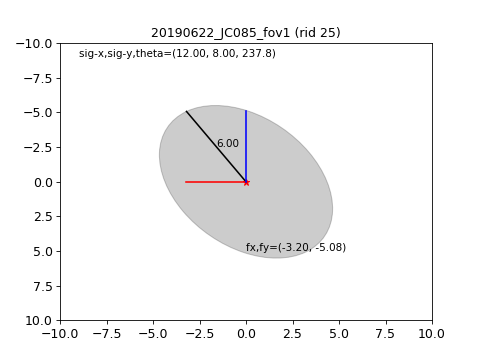

(-3.2, -5.08)


In [496]:
from matplotlib.patches import Ellipse

x0, y0 = (0, 0)
M = 12 #10
m = 8 #3
theta = np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


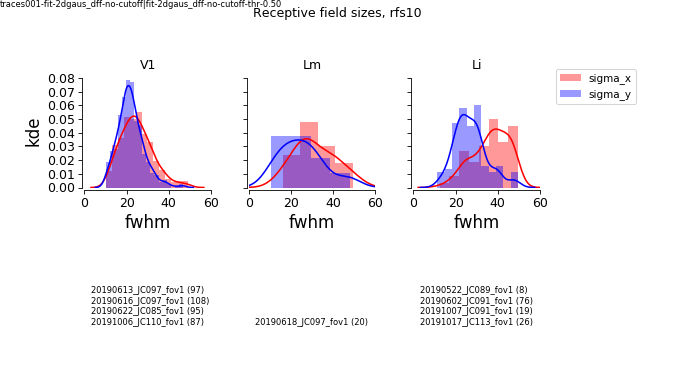

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'split_sigma_xy_fwhm_rfs10')


In [511]:
split_components = False
x_color = 'r'
y_color = 'b'
experiment = 'rfs10'

_df = df[df['experiment']==experiment].copy()

sigma_str = 'fwhm' if scale_sigma else 'sigma'
xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else 'sigma_'

visual_areas = ['V1', 'Lm', 'Li']
offset=0
fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)
for ax, visual_area in zip(axes.flat, visual_areas):
    g = _df[_df['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    count_str = '\n'.join(['%s (%i)' % (dkey, len(d)) for dkey, d in g.groupby(['datakey'])])
    #ax.set_ylim([0, 0.1])
    ax.set_xlim([0, xlim])
    ax.text(3, -0.1, count_str, fontsize=8)
    
    if scale_sigma:
        ax.set_xlabel('fwhm')
    else:
        ax.set_xlabel('sigma')

sns.despine(trim=True, offset=2)
    
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.5)
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('Receptive field sizes, %s' % experiment)

figname = 'split_%sxy_%s_%s' % (sz_metric, sigma_str, experiment)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))
print(compare_dir, figname)

In [361]:
df.groupby(['visual_area', 'experiment', 'datakey']).count()

r2  sigma_x  sigma_y  theta   x0  \
visual_area experiment datakey                                                  
Li          rfs        20190522_JC089_fov1    1        1        1      1    1   
                       20190602_JC091_fov1   28       28       28     28   28   
                       20191007_JC091_fov1   18       18       18     18   18   
                       20191017_JC113_fov1   10       10       10     10   10   
            rfs10      20190522_JC089_fov1    8        8        8      8    8   
                       20190602_JC091_fov1   76       76       76     76   76   
                       20191007_JC091_fov1   19       19       19     19   19   
                       20191017_JC113_fov1   26       26       26     26   26   
Lm          rfs        20190618_JC097_fov1   11       11       11     11   11   
            rfs10      20190618_JC097_fov1   20       20       20     20   20   
V1          rfs        20190613_JC097_fov1   61       61       61     61   61   
                       20190616_JC097_fov1   75       75       75     75   75   
                       20190622_JC085_fov1   64       64       64     64   64   
                       20191006_JC110_fov1   54       54       54     54   54   
            rfs10      20190613_JC097_fov1   97       97       97     97   97   
                       20190616_JC097_fov1  108      108      108    108  108   
                       20190622_JC085_fov1   95       95       95     95   95   
                       20191006_JC110_fov1   87       87       87     87   87   

                                             y0  animalid  cell  session  \
visual_area experiment datakey                                             
Li          rfs        20190522_JC089_fov1    1         1     1        1   
                       20190602_JC091_fov1   28        28    28       28   
                       20191007_JC091_fov1   18        18    18       18   
                       20191017_JC113_fov1   10        10    10       10   
            rfs10      20190522_JC089_fov1    8         8     8        8   
                       20190602_JC091_fov1   76        76    76       76   
                       20191007_JC091_fov1   19        19    19       19   
                       20191017_JC113_fov1   26        26    26       26   
Lm          rfs        20190618_JC097_fov1   11        11    11       11   
            rfs10      20190618_JC097_fov1   20        20    20       20   
V1          rfs        20190613_JC097_fov1   61        61    61       61   
                       20190616_JC097_fov1   75        75    75       75   
                       20190622_JC085_fov1   64        64    64       64   
                       20191006_JC110_fov1   54        54    54       54   
            rfs10      20190613_JC097_fov1   97        97    97       97   
                       20190616_JC097_fov1  108       108   108      108   
                       20190622_JC085_fov1   95        95    95       95   
                       20191006_JC110_fov1   87        87    87       87   

                                            avg_size   fx   fy  
visual_area experiment datakey                                  
Li          rfs        20190522_JC089_fov1         1    1    1  
                       20190602_JC091_fov1        28   28   28  
                       20191007_JC091_fov1        18   18   18  
                       20191017_JC113_fov1        10   10   10  
            rfs10      20190522_JC089_fov1         8    8    8  
                       20190602_JC091_fov1        76   76   76  
                       20191007_JC091_fov1        19   19   19  
                       20191017_JC113_fov1        26   26   26  
Lm          rfs        20190618_JC097_fov1        11   11   11  
            rfs10      20190618_JC097_fov1        20   20   20  
V1          rfs        20190613_JC097_fov1        61   61   61  
                       20190616_JC097_fov1        75   75 

In [109]:
df[df['visual_area']=='Lm']['datakey'].unique()

array(['20190618_JC097_fov1'], dtype=object)

## Average size by experiment-type (all fovs tested for control)

<IPython.core.display.Javascript object>


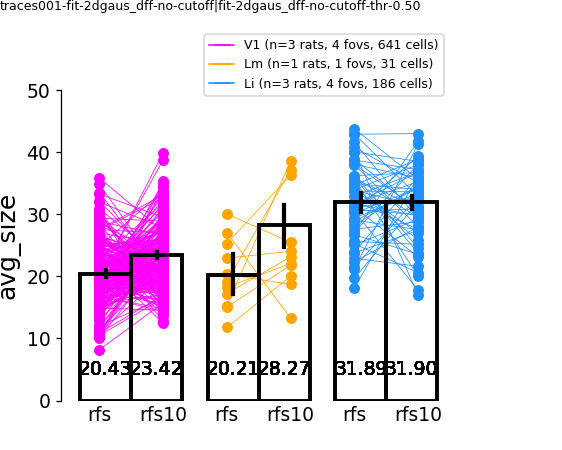

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'avg_size_fwhm_xy_by-area')


In [516]:
curr_metric = 'avg_size'

offset = 0.25
marker= 'o'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)


ax = compare_single_metric(df, curr_metric=curr_metric, ax=ax)

# Set x labels
ax.set_ylim([0, 50])
    
    
    
# aix=0
# for ai, visual_area in enumerate(visual_areas):

#     plotdf = df[df['visual_area']==visual_area]
#     a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
#     b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

#     by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
#     for pi, p in enumerate(by_exp):
#         ax.plot([aix-offset, aix+offset], p, marker=None, color=area_colors[visual_area], 
#                 alpha=1, lw=0.5,  zorder=0)
#     aix = aix+1

# sns.barplot("visual_area", curr_metric, data=df, 
#             hue='experiment', #zorder=0,
#             ax=ax, order=visual_areas,
#             errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
# ax.legend_.remove()

df.apply(annotateBars, ax=ax, axis=1)
    
# Set x labels
ylim = 50 if scale_sigma else 30
ax.set_ylim([0, ylim])
set_split_xlabels(ax, a_label='rfs', b_label='rfs10')


pl.subplots_adjust(left=0.12, right=0.8, top=0.8)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


figname = '%s_%s_xy_by-area' % (curr_metric, sigma_str)

pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)

### Compare RF stats for cells fit for BOTH conditions

In [519]:
common_rois = dict((dkey, np.intersect1d(d[d['experiment']=='rfs']['cell'], d[d['experiment']=='rfs10']['cell']))\
                     for dkey, d in df.groupby(['datakey']))

comdf = []
for visual_area, vdf in df.groupby(['visual_area']):
    currdf = pd.concat([g[g['cell'].isin(common_rois[dkey])] \
                        for dkey, g in vdf.groupby(['datakey'])], axis=0)

    a_vals = currdf[currdf['experiment']=='rfs']['avg_size']
    b_vals = currdf[currdf['experiment']=='rfs10']['avg_size']

    comdf.append(currdf)
    print("-----%s-------------------------" % visual_area)
    print("Paired t-test:")
    print spstats.ttest_rel(a_vals, b_vals) # Paired ttest (repeated measures)
    
    print("Wilcozon signed-rank (not assuming Gaussian):")
    print spstats.wilcoxon(a_vals, b_vals)   
    
comdf = pd.concat(comdf, axis=0)

-----Li-------------------------
Paired t-test:
Ttest_relResult(statistic=-2.0238834455616597, pvalue=0.05228210758740956)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=108.0, pvalue=0.010444400581851145)
-----Lm-------------------------
Paired t-test:
Ttest_relResult(statistic=-1.619210183233768, pvalue=0.1663270470773888)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=5.0, pvalue=0.24886387493792206)
-----V1-------------------------
Paired t-test:
Ttest_relResult(statistic=-7.0054593224410526, pvalue=3.8516747073728414e-11)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=4588.0, pvalue=1.1602391906359055e-10)


In [385]:
comdf.head()

r2    sigma_x    sigma_y     theta         x0         y0 animalid  \
0  0.745698  11.889190   7.591428  0.109926  29.626002  -6.651742    JC091   
1  0.703492   9.874203  11.439578  1.811255  31.887327  -7.297954    JC091   
2  0.657171  16.298375  11.077365  0.134737  33.680634  -8.699873    JC091   
4  0.652976  17.029419   9.960455  0.233049  32.226918  -4.272079    JC091   
5  0.680329  19.583595  16.937520  0.544099  45.646154 -21.471942    JC091   

   cell              datakey experiment   session visual_area   avg_size  \
0    16  20190602_JC091_fov1        rfs  20190602          Li   9.740309   
1    33  20190602_JC091_fov1        rfs  20190602          Li  10.656890   
2    34  20190602_JC091_fov1        rfs  20190602          Li  13.687870   
4    37  20190602_JC091_fov1        rfs  20190602          Li  13.494937   
5   295  20190602_JC091_fov1        rfs  20190602          Li  18.260558   

          fx         fy  
0  11.817430   1.304297  
1   2.724317  11.110447  
2  16.150658   2.189354  
4  16.569059   3.932859  
5  16.755611  10.137392

In [520]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

formula = 'avg_size ~ C(experiment) * C(visual_area)'
model = ols(formula, data=comdf).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

sum_sq     df            F         PR(>F)
Intercept                     29956.717229    1.0  1310.099701  1.071929e-136
C(experiment)                   127.771289    1.0     5.587833   1.850035e-02
C(visual_area)                 3201.563710    2.0    70.007131   2.865097e-27
C(experiment):C(visual_area)      3.287336    2.0     0.071883   9.306505e-01
Residual                      10518.352091  460.0          NaN            NaN

In [521]:
model = ols('avg_size ~ visual_area + experiment', comdf).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:               avg_size   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     108.9
Date:                Fri, 10 Jul 2020   Prob (F-statistic):           2.53e-53
Time:                        19:55:09   Log-Likelihood:                -1387.5
No. Observations:                 466   AIC:                             2783.
Df Residuals:                     462   BIC:                             2800.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              31.5719    

In [522]:
print(model.f_test([0, 1, -1, 0]))

<F test: F=array([[ 6.62733246]]), p=0.0103529201469, df_denom=462, df_num=1>


In [523]:
result = ols(formula='avg_size ~ visual_area + experiment + visual_area * experiment', data=comdf).fit()    
print(result.summary())    

                            OLS Regression Results                            
Dep. Variable:               avg_size   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     65.09
Date:                Fri, 10 Jul 2020   Prob (F-statistic):           2.58e-51
Time:                        19:55:14   Log-Likelihood:                -1387.4
No. Observations:                 466   AIC:                             2787.
Df Residuals:                     460   BIC:                             2812.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [524]:
def annotateBars(row, ax=ax, fontsize=12): 
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
                    ha='center', va='center', fontsize=fontsize, color='k', 
                    rotation=0, xytext=(0, 20),
             textcoords='offset points')
        
    

In [525]:
def compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

    offset = 0.25
    
    if ax is None:
        fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
    
    # Plot paired values
    aix=0
    for ai, visual_area in enumerate(visual_areas):

        plotdf = comdf[comdf['visual_area']==visual_area]
        a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
        b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

        by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
        for pi, p in enumerate(by_exp):
            ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
                    alpha=1, lw=0.5,  zorder=0)
        aix = aix+1

    # Plot average
    sns.barplot("visual_area", curr_metric, data=comdf, 
                hue='experiment', #zorder=0,
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    ax.legend_.remove()

    set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
    return ax


<IPython.core.display.Javascript object>


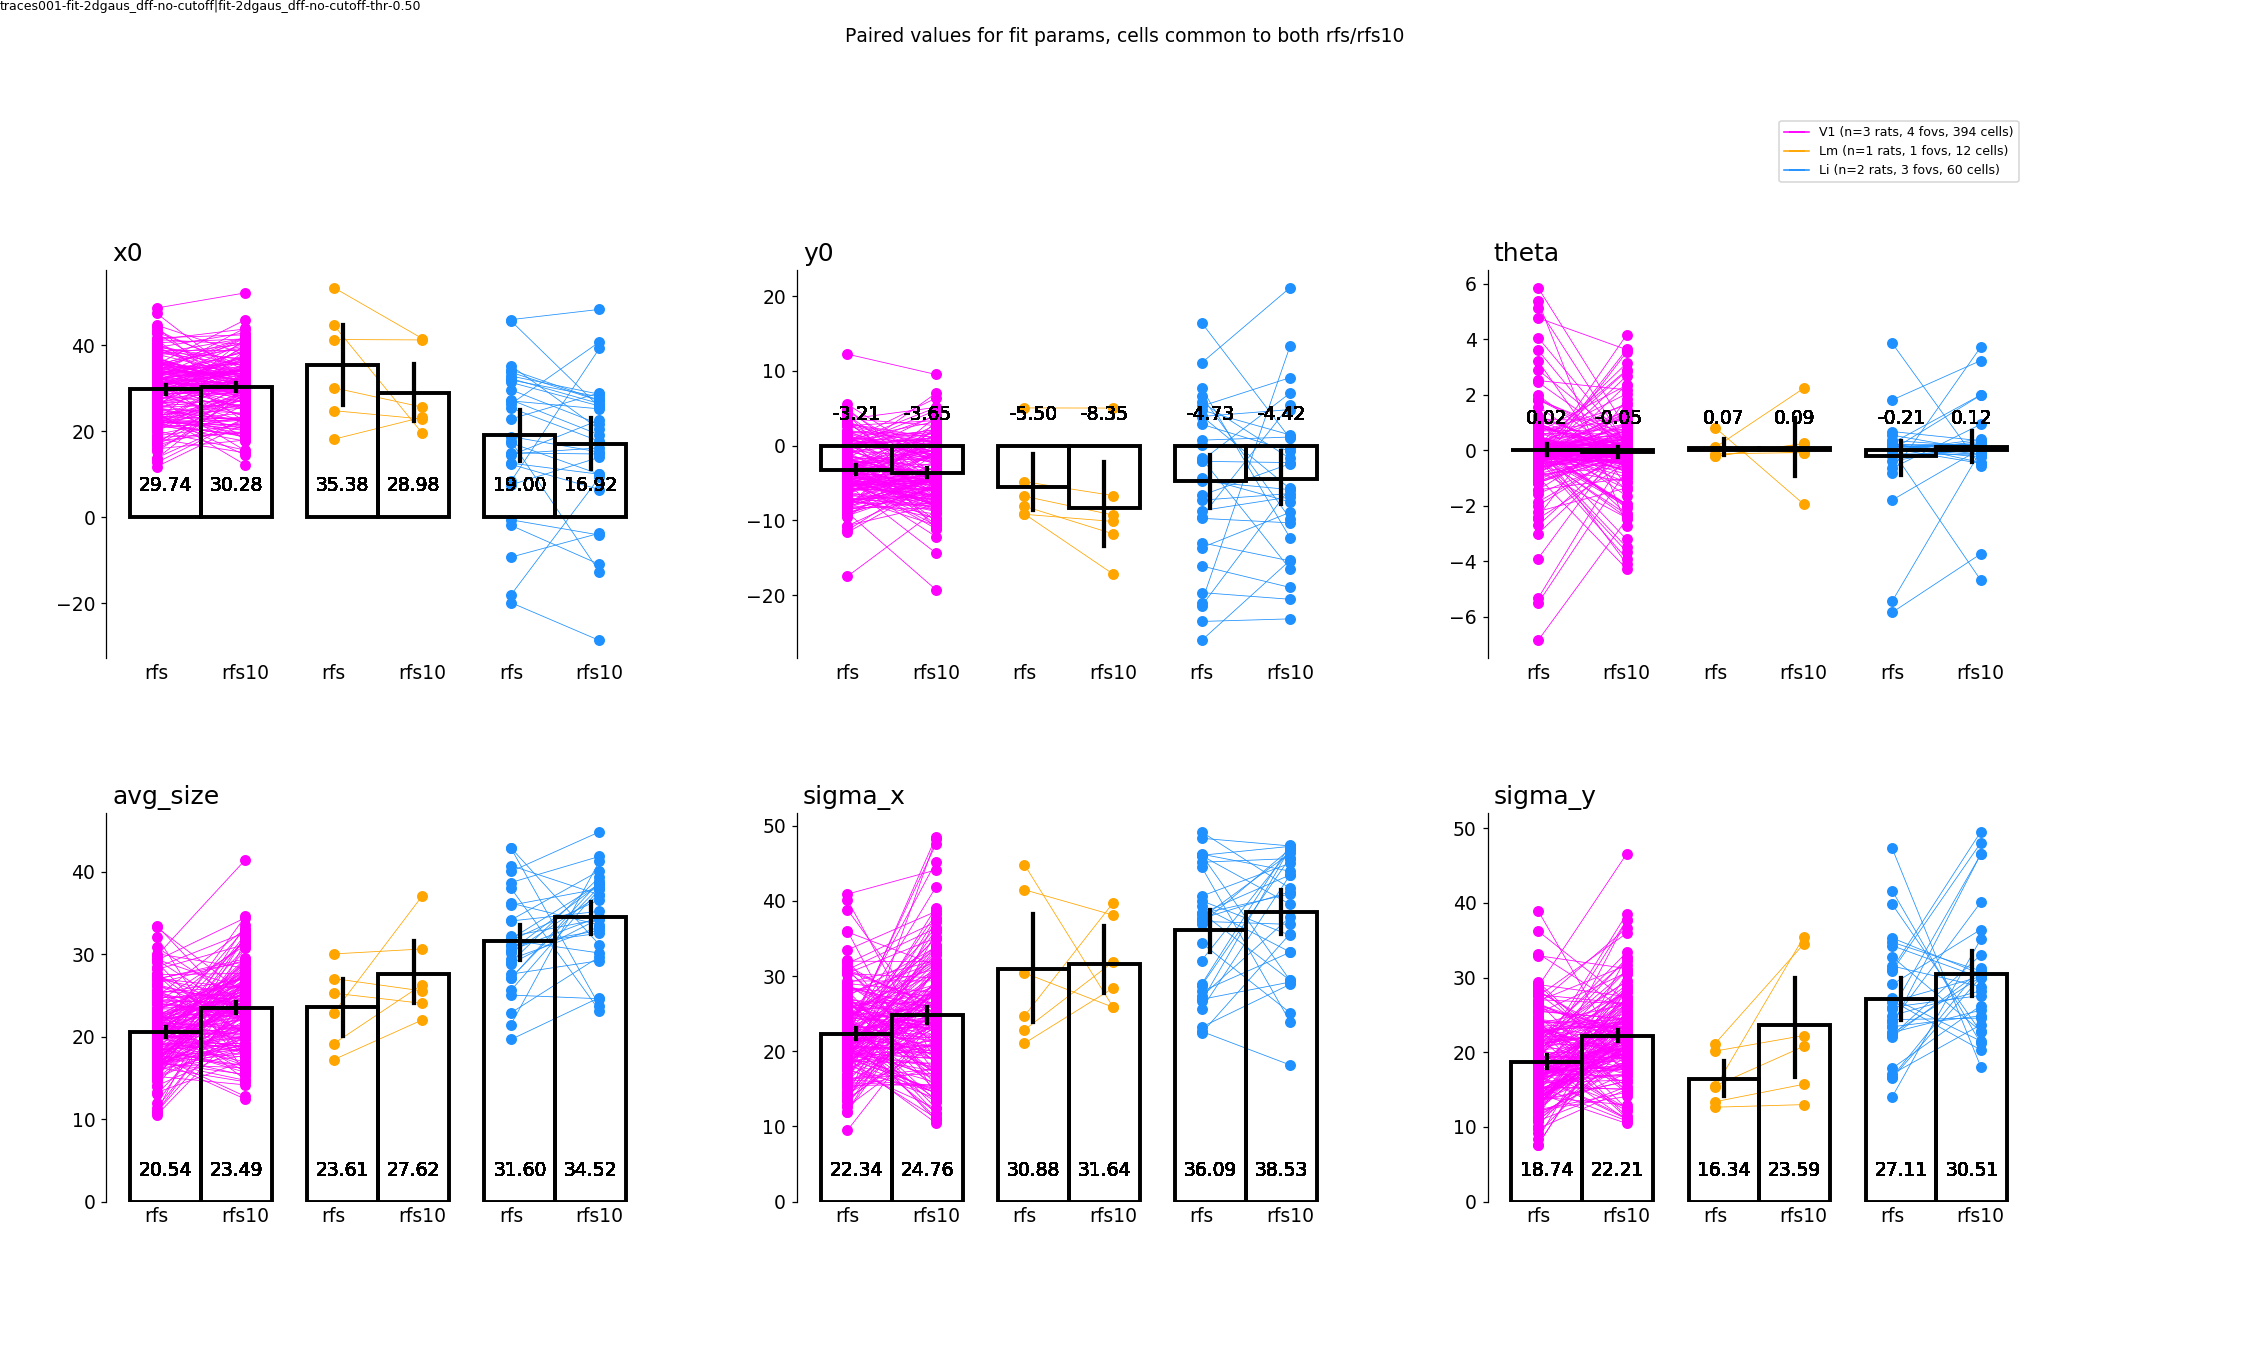

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'fitparams_cells-common-to-both-condns_sigma_xy_fwhm')


In [528]:
split_components = False

offset = 0.25
marker= 'o'

params = ['x0', 'y0', 'theta', 'avg_size']
sz_metric = 'f' if split_components else 'sigma_'
params.extend(['%sx' % sz_metric, '%sy' % sz_metric])
    

fig, axn = pl.subplots(2, 3, figsize=(20,12), dpi=dpi)
fig.patch.set_alpha(0)

for ax, curr_metric in zip(axn.flat, params):

    ax.patch.set_alpha(0)
    
    # Plot paired values
    ax = compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)
    
    ax.set_title(curr_metric, loc='left', fontsize=16)
    ax.set_ylabel('')

    # Annotate bars
    comdf.apply(annotateBars, ax=ax, axis=1)
    
# Adjust figure size
pl.subplots_adjust(left=0.05, right=0.9, top=0.8, wspace=0.3, hspace=0.4)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 2.8), fontsize=8)

fig.suptitle('Paired values for fit params, cells common to both rfs/rfs10')

# Save
figname = 'fitparams_cells-common-to-both-condns_%sxy_%s' % (sz_metric, sigma_str)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)    

In [400]:
# curr_metric = 'avg_size'

# fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
# fig.patch.set_alpha(0)
# ax.patch.set_alpha(0)

# ax = compare_single_metric(comdf, curr_metric='avg_size', ax=ax)

# # Set x labels
# ax.set_ylim([0, 50])
    
# # Adjust figure size
# pl.subplots_adjust(left=0.12, right=0.7, top=0.8)
# label_figure(fig, data_id)

# # Get counts of samples for legend
# legend_elements = get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
# ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)

# Save
# figname = '%s_cells-common-to-both-condns' % curr_metric
# pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

# print(compare_dir, figname)    

#### Plot join between rfs/rfs10

<IPython.core.display.Javascript object>


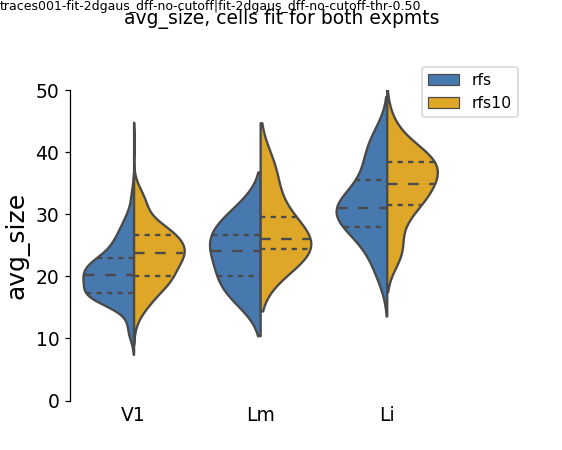

In [529]:
curr_metric = 'avg_size'

ylim = 50 if scale_sigma else 30
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.violinplot(x='visual_area', y=curr_metric, data=comdf, ax=ax,
               order=visual_areas,
              hue='experiment', palette=bi_palette, split=True,
               inner='quartile', scale='count')

ax.set_ylim([0, ylim])
ax.tick_params(axis='x', size=0)
ax.set_xlabel('')

fig.suptitle('%s, cells fit for both expmts' % curr_metric)
pl.subplots_adjust(right=0.8, top=0.8)
label_figure(fig, data_id)

ax.legend(bbox_to_anchor=(1.2, 1.1))
sns.despine(bottom=True, trim=True)

#### Calculate difference between rfs/rfs10 for size

In [530]:
diffs = []
for v, vdf in comdf.groupby(['visual_area']):
    a_vals = vdf[vdf['experiment']=='rfs'][curr_metric].values
    b_vals = vdf[vdf['experiment']=='rfs10'][curr_metric].values
    diffs.append(pd.DataFrame({'visual_area': [v for _ in np.arange(0, len(a_vals))],
                               'difference': b_vals - a_vals}))
diffs = pd.concat(diffs, axis=0)


<IPython.core.display.Javascript object>


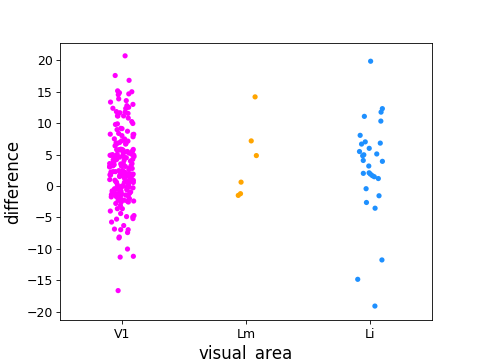

In [531]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='difference', data=diffs,
              order=visual_areas, palette=area_colors, ax=ax)

In [532]:
params = ['x0', 'y0', 'theta', 'sigma_x', 'sigma_y', 'avg_size']

<IPython.core.display.Javascript object>


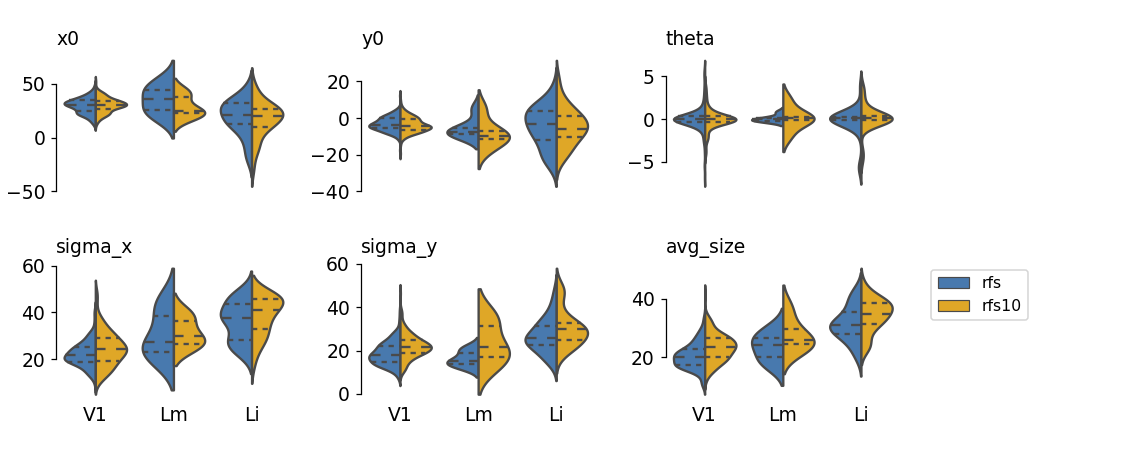

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'all-metrics_cells-common-to-both-condns_fwhm')


In [533]:
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    sns.violinplot(x='visual_area', y=param, data=comdf, ax=ax,
                   order=visual_areas,
                  hue='experiment', palette=bi_palette, split=True,
                   scale='count', inner='quartile')
    if ai < 5:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1.1, 1))
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_cells-common-to-both-condns_%s' % sigma_str
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)    

# Visualize general stats

In [534]:
scale_sigma = True


#### Check size distns for ALL dataset

In [535]:
#### How to deal with repeat FOVs (manual)

#### Get metadata
dsets_nof = ret.get_metadata(traceid=traceid, fov_type=fov_type, state=state, filter_by=None)
rfdata_nof = dsets_nof[dsets_nof['experiment'].isin(['rfs', 'rfs10'])]
# rfdata_nof.groupby(['visual_area', 'experiment']).count()

#### Check for any datasets that need RF fits
excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
                     'JC080_20190602_FOV1_zoom2p0x',
                     'JC113_20191108_FOV1_zoom2p0x', 'JC113_20191108_FOV2_zoom2p0x']
rf_dpaths_nof, _ = get_fit_dpaths(rfdata_nof, fit_desc=fit_desc, excluded_sessions=excluded_sessions)

#### Get RF dataframe for all datasets (filter to include only good fits)
all_df_nof = aggregate_rf_data(rf_dpaths_nof, scale_size=scale_sigma, verbose=False)
all_df_nof.groupby(['visual_area', 'experiment'])['datakey'].count()


N dpaths: 46, N unfit: 0
N datasets included: 46, N sessions excluded: 4


visual_area  experiment
Li           rfs            31
             rfs10         386
Lm           rfs           166
             rfs10         185
V1           rfs           529
             rfs10         531
Name: datakey, dtype: int64

In [536]:
r_df_nof= all_df_nof[all_df_nof['r2'] > fit_thr].copy().reset_index(drop=True)
dkey_dict_nof = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
                 for v, vdf in r_df_nof.groupby(['visual_area'])) 
r_df_nof['datakey_ix'] = [dkey_dict_nof[r_df_nof['visual_area'][i]][r_df_nof['datakey'][i]] \
                      for i in r_df_nof.index.tolist()]    
    
    

<IPython.core.display.Javascript object>


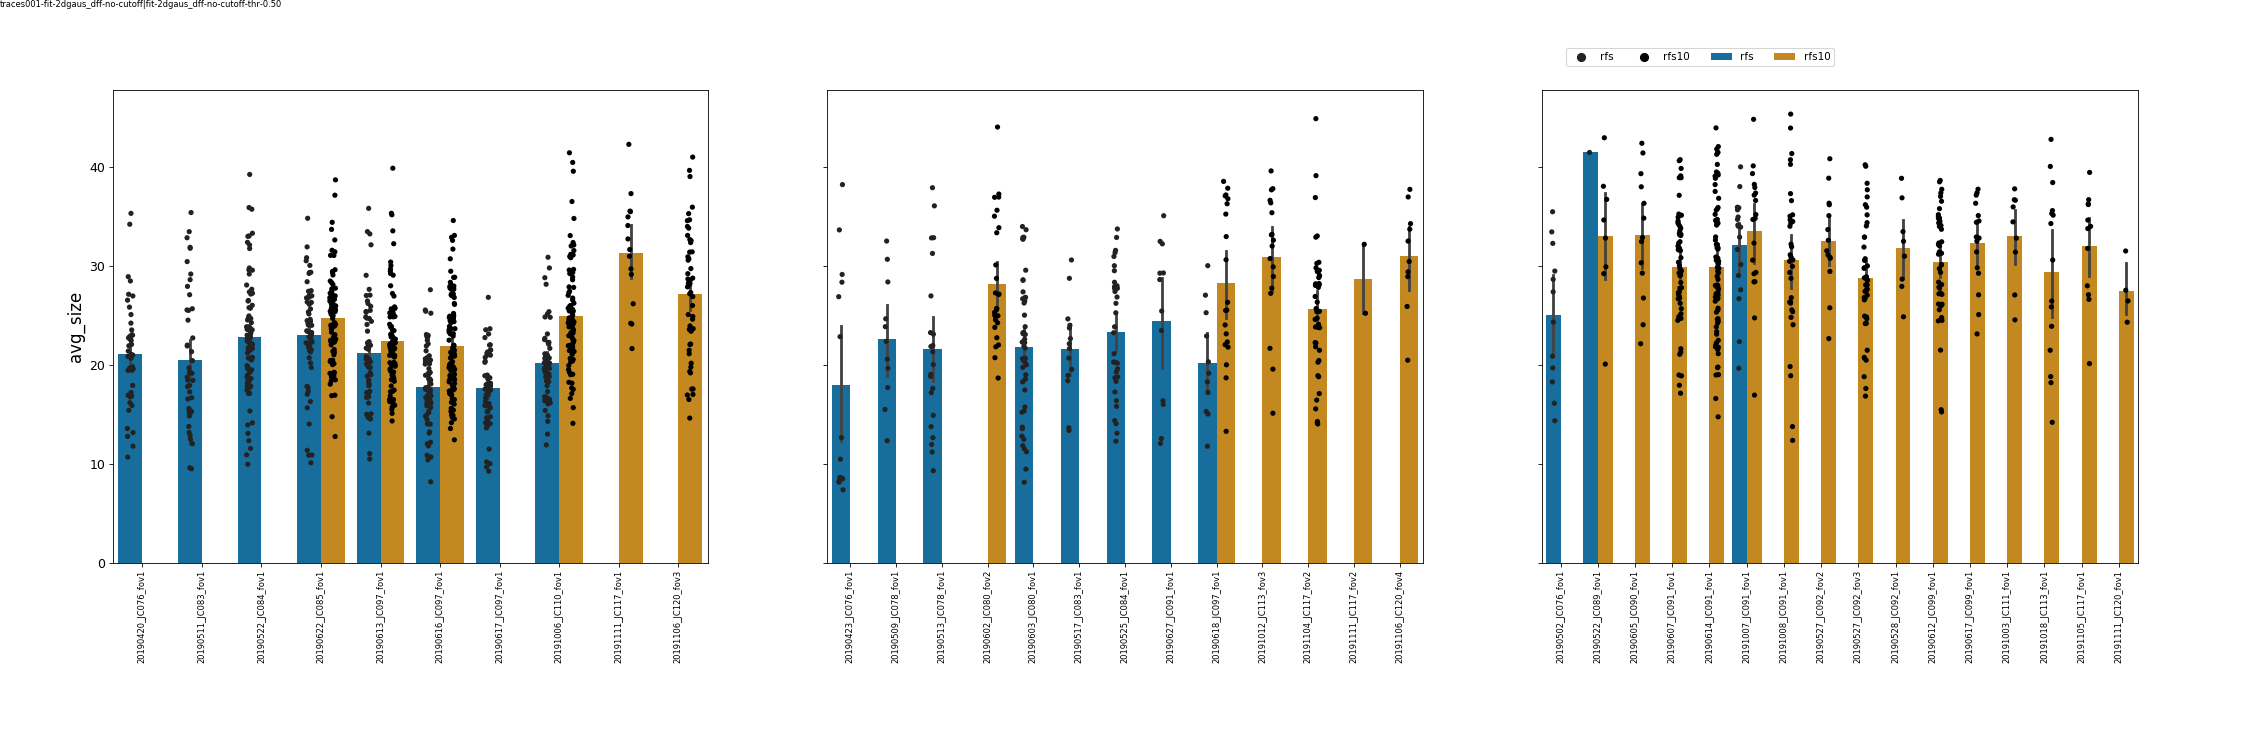

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'avg_size_by-dataset_by-experiment_ALL_fwhm')


In [537]:
fig, axes = pl.subplots(1,3, figsize=(30, 10), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    
    plotdf = r_df_nof[r_df_nof['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict_nof[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict_nof[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
        
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95, wspace=0.2)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_ALL_%s' % (curr_metric, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

## Drop repeats

In [538]:
#### How to deal with repeat FOVs (manual)
filter_by = 'drop_repeats'


genstats_dir = os.path.join(outdir, 'general-stats', filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print genstats_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


In [539]:

#### Get metadata
dsets = ret.get_metadata(traceid=traceid, fov_type=fov_type, state=state, filter_by=filter_by)
rfdata = dsets[dsets['experiment'].isin(['rfs', 'rfs10'])]
rfdata.groupby(['visual_area', 'experiment']).count()

#### Check for any datasets that need RF fits
excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
                    'JC080_20190602_FOV1_zoom2p0x']
rf_dpaths, nostats = get_fit_dpaths(rfdata, fit_desc=fit_desc, excluded_sessions=excluded_sessions)
print(nostats)

#### Get RF dataframe for all datasets (filter to include only good fits)
all_df = aggregate_rf_data(rf_dpaths, verbose=False, scale_size=scale_sigma)
all_df.groupby(['visual_area', 'experiment'])['datakey'].count()


N dpaths: 46, N unfit: 0
N datasets included: 46, N sessions excluded: 2
[]


visual_area  experiment
Li           rfs            31
             rfs10         386
Lm           rfs           166
             rfs10         185
V1           rfs           529
             rfs10         531
Name: datakey, dtype: int64

In [441]:
nostats

[]

In [540]:
r_df = all_df[all_df['r2'] > fit_thr].copy().reset_index(drop=True)
dkey_dict = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
                 for v, vdf in r_df.groupby(['visual_area'])) 
r_df['datakey_ix'] = [dkey_dict[r_df['visual_area'][i]][r_df['datakey'][i]] \
                      for i in r_df.index.tolist()]    
    
    

<IPython.core.display.Javascript object>


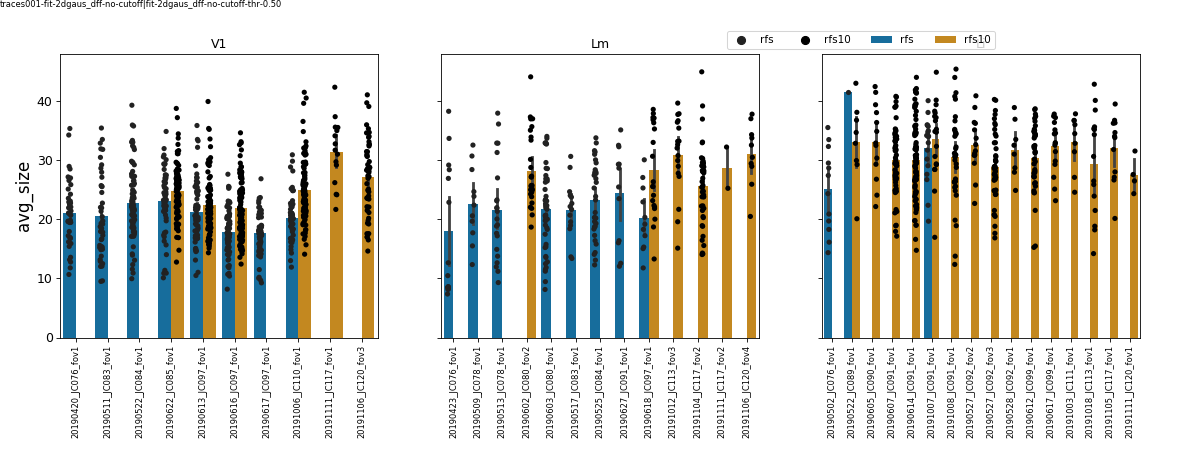

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [541]:
fig, axes = pl.subplots(1,3, figsize=(16, 6), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    plotdf = r_df[r_df['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_title(visual_area)
    
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.56, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_%s_%s' % (curr_metric, filter_by, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))


In [484]:
all_df[all_df['r2']>0.5].groupby(['visual_area', 'experiment']).count()

r2  sigma_x  sigma_y  theta   x0   y0  animalid  \
visual_area experiment                                                     
Li          rfs          31       31       31     31   31   31        31   
            rfs10       386      386      386    386  386  386       386   
Lm          rfs         166      166      166    166  166  166       166   
            rfs10       124      124      124    124  124  124       124   
V1          rfs         495      495      495    495  495  495       495   
            rfs10       456      456      456    456  456  456       456   

                        cell  datakey  session  avg_size  
visual_area experiment                                    
Li          rfs           31       31       31        31  
            rfs10        386      386      386       386  
Lm          rfs          166      166      166       166  
            rfs10        124      124      124       124  
V1          rfs          495      495      495       495  
            rfs10        456      456      456       456

In [483]:
all_df[(all_df['visual_area']=='Lm') & (all_df['experiment']=='rfs10')].count()

r2             185
sigma_x        185
sigma_y        185
theta          185
x0             185
y0             185
animalid       185
cell           185
datakey        185
experiment     185
session        185
visual_area    185
avg_size       185
dtype: int64

# Get datasets to analyze

In [542]:
# Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in all_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs10' if visual_area=='Li' else 'rfs'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    
    vdf = g[g['experiment']==expname]
#     if len(vdf)==0:
#         vdf = g[g['experiment']==altname]
    rdf_list.append(vdf)
    
rdf = pd.concat(rdf_list)

# rdf = pd.concat([vdf[vdf['experiment']=='rfs10'] if v=='Li' else vdf[vdf['experiment']=='rfs'] \
#     for v, vdf in all_df.groupby(['visual_area'])])
rfdf = rdf[rdf['r2']>fit_thr]
rfdf.groupby(['visual_area']).count()

r2  sigma_x  sigma_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                    
Li           386      386      386    386  386  386       386   386      386   
Lm           166      166      166    166  166  166       166   166      166   
V1           495      495      495    495  495  495       495   495      495   

             experiment  session  avg_size  
visual_area                                 
Li                  386      386       386  
Lm                  166      166       166  
V1                  495      495       495

#### 1. Average RF size

<IPython.core.display.Javascript object>


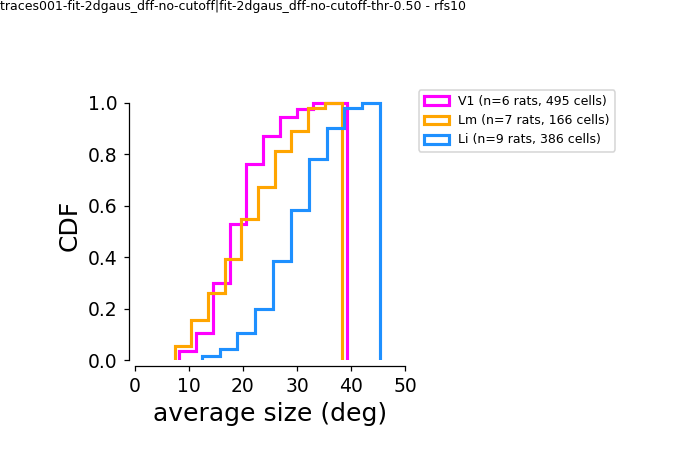

avg_size_drop_repeats_cdf


In [543]:
curr_metric = 'avg_size'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30
#for experiment, expdf in rfdf.groupby(['experiment']):

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = compare_rf_size(rfdf, cdf=cdf, ax=ax, alpha=1)
ax.set_xlim([0, max_size])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_%s_%s' % (curr_metric, filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

In [467]:
mean_sizes

visual_area animalid              datakey   avg_size
0           Li    JC076  20190502_JC076_fov1  11.004152
1           Li    JC089  20190522_JC089_fov1  14.360358
2           Li    JC090  20190605_JC090_fov1  13.991954
3           Li    JC091  20190607_JC091_fov1  12.655392
4           Li    JC091  20190614_JC091_fov1  12.663322
5           Li    JC091  20191007_JC091_fov1  14.820623
6           Li    JC091  20191008_JC091_fov1  13.087617
7           Li    JC092  20190527_JC092_fov2  13.648001
8           Li    JC092  20190527_JC092_fov3  12.149766
9           Li    JC092  20190528_JC092_fov1  13.511024
10          Li    JC099  20190612_JC099_fov1  13.296753
11          Li    JC099  20190617_JC099_fov1  13.994219
12          Li    JC111  20191003_JC111_fov1  14.668565
13          Li    JC113  20191018_JC113_fov1  13.027315
14          Li    JC117  20191105_JC117_fov1  14.426586
15          Li    JC120  20191111_JC120_fov1  11.494606
16          Lm    JC076  20190423_JC076_fov1   4.913208
17          Lm    JC078  20190509_JC078_fov1   9.523072
18          Lm    JC078  20190513_JC078_fov1   8.799553
19          Lm    JC080  20190602_JC080_fov2  10.937951
20          Lm    JC080  20190603_JC080_fov1   9.391324
21          Lm    JC083  20190517_JC083_fov1   9.318220
22          Lm    JC084  20190525_JC084_fov1  10.022415
23          Lm    JC091  20190627_JC091_fov1  11.505889
24          Lm    JC097  20190618_JC097_fov1   8.152569
25          Lm    JC113  20191012_JC113_fov3  13.753265
26          Lm    JC117  20191104_JC117_fov2  11.074110
27          Lm    JC117  20191111_JC117_fov2  12.217154
28          Lm    JC120  20191106_JC120_fov4  13.401152
29          V1    JC076  20190420_JC076_fov1   8.963784
30          V1    JC083  20190511_JC083_fov1   8.150607
31          V1    JC084  20190522_JC084_fov1   9.505428
32          V1    JC085  20190622_JC085_fov1   9.891271
33          V1    JC097  20190613_JC097_fov1   8.756855
34          V1    JC097  20190616_JC097_fov1   7.440158
35          V1    JC097  20190617_JC097_fov1   7.472117
36          V1    JC110  20191006_JC110_fov1   8.566790
37          V1    JC117  20191111_JC117_fov1  13.477556
38          V1    JC120  20191106_JC120_fov3  11.909219

#### Plot bar and individual fov averages

<IPython.core.display.Javascript object>


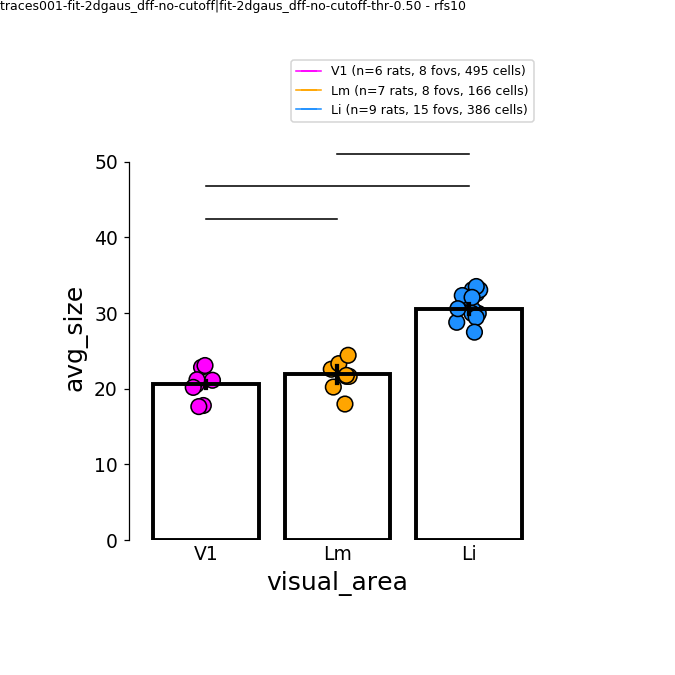

********* rfs10 - avg_size **********
Statistics=36257.000, p=0.012
Different distribution (reject H0)
Statistics=22207.000, p=0.000
Different distribution (reject H0)
Statistics=12079.000, p=0.000
Different distribution (reject H0)
[(('V1', 'Lm'), True, 0.01168304016163599), (('V1', 'Li'), True, 4.4230317262061704e-85), (('Lm', 'Li'), True, 3.4697569301014117e-31)]
****************************
avg_size_fwhm_groupby-datakey_mean-fov_drop_repeats__multicomp-holm_ci


In [569]:
curr_metric = 'avg_size'
multi_comp_test = 'holm'
mean_metric = 'mean'
groupby = 'datakey'

# for experiment, expdf in rfdf.groupby(['experiment']):

# Average RF sizes for each FOV
if groupby is not None:
    grped = rfdf.groupby(['visual_area', groupby])
    group_str = 'groupby-%s' % groupby
else:
    grped = rfdf.groupby(['visual_area'])
    group_str = ''


if mean_metric == 'median':
    mean_sizes = grped.median()['avg_size'].reset_index()
else:
    mean_sizes = grped.mean()['avg_size'].reset_index()

fig, ax = pl.subplots(figsize=(6,6), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=rfdf, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=mean_sizes, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(rfdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
annotate_stats_areas(statresults, ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_%s_%s_%s-fov_%s__multicomp-%s_ci' % (curr_metric, sigma_str, group_str, mean_metric, filter_by, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

In [547]:

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(mean_sizes, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
#annotate_stats_areas(statresults, ax)
print("****************************")

********* rfs10 - avg_size **********
Statistics=19.000, p=0.095
Same distribution (fail to reject H0)
Statistics=0.000, p=0.000
Different distribution (reject H0)
Statistics=0.000, p=0.000
Different distribution (reject H0)
[(('V1', 'Lm'), False, 0.094631481657512728), (('V1', 'Li'), True, 0.00018401959621917283), (('Lm', 'Li'), True, 0.00018401959621917283)]
****************************


#### Plot distn of all rf sizes

<IPython.core.display.Javascript object>


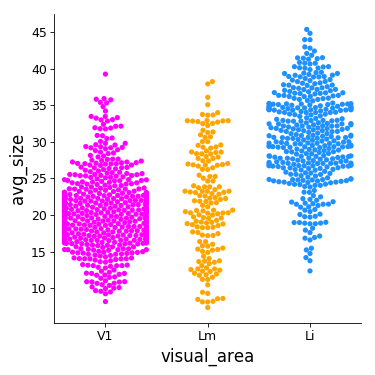

avg-size-distns_fwhm_combine-all_by-area_swarm


In [557]:
plot_kind = 'swarm'
fg = sns.catplot(x="visual_area", y="avg_size", data=rfdf,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = 'avg-size-distns_%s_combine-all_by-area_%s' % (sigma_str, plot_kind)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

#### Look at N cells fit 

In [490]:
countdf = rfdf.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)


<IPython.core.display.Javascript object>


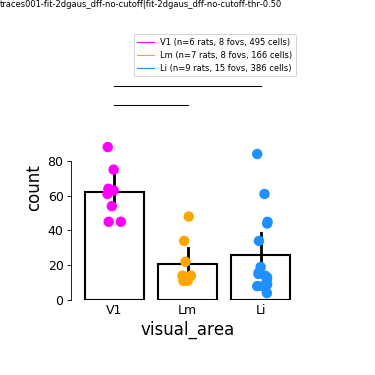

********* rfs - n_cells **********
Statistics=2.000, p=0.001
Different distribution (reject H0)
Statistics=11.500, p=0.001
Different distribution (reject H0)
Statistics=59.000, p=0.487
Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.0028544124350692295), (('V1', 'Li'), True, 0.0028544124350692295), (('Lm', 'Li'), False, 0.48710091967407448)]
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'n_cells_avg-fov_drop_repeats__multicomp-holm')


In [491]:
curr_metric = 'n_cells'
fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')


#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)



print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
annotate_stats_areas(statresults, fg.ax)
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_avg-fov_%s__multicomp-%s' % (curr_metric, filter_by, multi_comp_test)
fg.fig.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [571]:
params

['x0', 'y0', 'theta', 'sigma_x', 'sigma_y', 'avg_size']

<IPython.core.display.Javascript object>


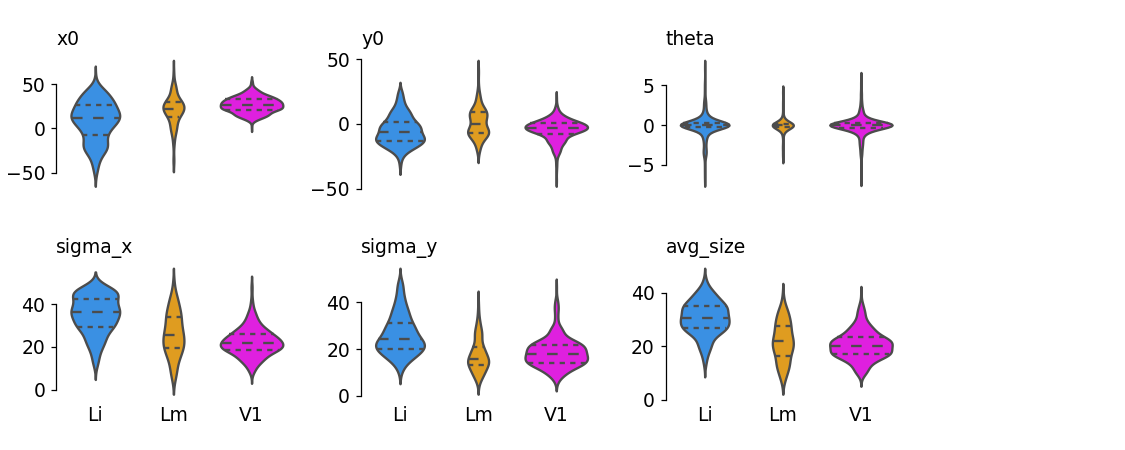

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'all-metrics_drop_repeats_fwhm')


In [579]:
plot_type = 'violin'

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors, dodge=True)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_%s_%s' % (filter_by, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))

print(compare_dir, figname)    

# Compare cortical position vs. VF position

In [55]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = coords.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = coords.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [56]:
retinodir = os.path.join(rfdir, 'retinotopic-organization')
if not os.path.exists(retinodir):
    os.makedirs(retinodir)
print("Saving retino comparisons to: %s" % retinodir)

Saving retino comparisons to: /n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff/retinotopic-organization


In [57]:
rfdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff'

#### Load converted RF positions

In [58]:
get_positions = False
pos_fpath = os.path.join(rfdir, 'rf_positions_no-repeats.pkl')

if os.path.exists(pos_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(pos_fpath, 'rb') as f:
            aggr = pkl.load(f)
            posdf = aggr['posdf']
    except Exception as e:
        get_positions = True
else:
    get_positions = True
    
if get_positions:
    print("Calculating RF coord conversions...")
    pos_list = []
    for visual_area in visual_areas:
        d = rfdf[rfdf['visual_area']==visual_area]
        for (animalid, session, fov), g in d.groupby(['animalid', 'session', 'fov']):
            rffits = g.copy()
            rffits.index = g.index
            posdf = get_fov_coordinates(animalid, session, fov, rffits)
            pos_list.append(posdf)

    posdf = pd.concat(pos_list, axis=0).reset_index()
    with open(pos_fpath, 'wb') as f:
        aggr = {'posdf': posdf}
        pkl.dump(aggr, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e280bf_traces001_113086_traces001_caa531_traces001_d04d75_traces001_5735eb/data_arrays/np_subtracted.npz
NP_subtracted offset was: 62.54
adding NP offset... (NP baseline offset: 284.05)
((258720, 300), (300,), ())
... updating self
... ... loaded traces
Created 300 contours for rois.
[JC076] 20190501 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
...

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 314 contours for rois.
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190615|FOV2_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC097/20190615/FOV2_zoom2p0x/combined_rfs10_static/traces/traces001_82391c_traces001_5005be_traces001_b13324/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC097 | 20190615 | FOV2_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 338 contours for rois.
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_30490f_traces001_8ad808/data_arrays/np_subtracted.npz
NP_subtracted offset was: 199.97
adding NP offset... (NP baseline offset: 777.42)
((58740, 432), (432,), ())
... updating self
... ... loaded traces
Created 432 contours for rois.
[JC097] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC097|20190617|F

((239232, 295), (295,), ())
... adjusting for equal reps / condn...
... updating self
... ... loaded traces
Created 295 contours for rois.
[JC078] 20190513 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC078 | 20190513 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC078|20190513|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 118.47
adding NP offset... (NP baseline offset: 565.59)
((246708, 280), (280,), ())
... updating self
... ... loaded traces
Created 280 contours for rois.
[JC080] 20190506 - FOV1_zoom2p0x:  Getting anatomicals...
... Fou

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 183 contours for rois.
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs'])
... ... loading: rfs
... ... got rois
... ... (renamed traceid)
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... loading data array
/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_48087b_traces001_eb1ab1_traces001_34291b_traces001_83220d_traces001_15ae76_traces001_b0ea86/data_arrays/np_subtracted.npz
NP_subtracted offset was: 76.00
adding NP offset... (NP baseline offset: 762.38)
((246708, 275), (275,), ())
... updating self
... ... loaded traces
Created 275 contours for rois.
[JC083] 20190508 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190508 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment da

NP_subtracted offset was: 12.59
adding NP offset... (NP baseline offset: 951.29)
((65340, 191), (191,), ())
... updating self
... ... loaded traces
Created 191 contours for rois.
[JC120] 20191106 - FOV4_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC120 | 20191106 | FOV4_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC120|20191106|FOV4_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC120/20191106/FOV4_zoom2p0x/combined_rfs10_static/traces/traces001_0576f9_traces001_b3ca84/data_arrays/np_subtracted.npz
NP_subtracted offset was: 39.18
adding NP offset... (NP baseline offset: 655.99)
((43560, 252), (252,), ())
... updating self
... ... loaded traces
Created 252 contours for rois.
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 271 contours for rois.
[JC091] 20190602 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190602 | FOV1_zoom2p0x | rfs | traces001
Found 68 raw file arrays.
**** File 1 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run1
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last fra

There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 7 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 350.52801598995484)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -89.3023850085
... processing trace type: np_subtracted
('drift offset:', 59.605280853702936)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -344.885500791
... processing trace type: raw
('drift offset:', 319.97047624771892)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -402.237215909
STIM TYPE: gratings
**** File 9 of 68 *****
*** Excluding: []
/n/coxfs01

('drift offset:', 312.03211695112469)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -248.714653201
STIM TYPE: gratings
**** File 16 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run2
N tsecs: 2911
There are 252 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 4 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 344.5981799057451)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.8782403771
... processing trace type: np_subtracted
('drift offset:', 58.358003168446473)
Showing initial drift correction (quantile: 0.10)
Min value

('drift offset:', 54.006579914972981)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -264.829173906
... processing trace type: raw
('drift offset:', 310.74628399077261)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -257.655776515
STIM TYPE: gratings
**** File 24 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run3
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 6 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 338.84951805175473)
Showing initial drift correction (quantile: 0.10)
Min value for all 

('drift offset:', 334.73203512998327)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -74.082361516
... processing trace type: np_subtracted
('drift offset:', 63.819681362169057)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -359.407776414
... processing trace type: raw
('drift offset:', 313.08143192928441)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -367.260357481
STIM TYPE: gratings
**** File 32 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run4
N tsecs: 2911
There are 270 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 3 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimul

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currdf['ix'] = [total_ix for _ in range(currdf.shape[0])]
/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currf0['ix'] = [total_ix for _ in range(currdf.shape[0])]



('drift offset:', 50.367677066395402)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -303.654811357
... processing trace type: raw
('drift offset:', 285.18829935342387)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -283.293969131
STIM TYPE: gratings
**** File 36 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 0 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimulus', u'type', u'phase'])
... processing trace type: neuropil
('drift offset:', 314.42321350828666)
Showing initial drift correction (quantile: 0.10)
Min value for all

('drift offset:', 312.97108705112311)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -70.1804623415
... processing trace type: np_subtracted
('drift offset:', 53.687284570494505)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -249.718819594
... processing trace type: raw
('drift offset:', 287.47798808372193)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -277.856343284
STIM TYPE: gratings
**** File 44 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run5
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2896
... File: 8 (has 2911 frames)
... asking for 11 extra frames...
... Last frame to align: 2922 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimu

('drift offset:', 423.63992371150766)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.4368663594
... processing trace type: np_subtracted
('drift offset:', 89.243632775241736)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -295.380285562
... processing trace type: raw
('drift offset:', 403.75418788362231)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -308.34469697
STIM TYPE: gratings
**** File 52 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run6
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 5 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stimul

... processing trace type: neuropil
('drift offset:', 404.58304855040677)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.8106235566
... processing trace type: np_subtracted
('drift offset:', 78.818183183642475)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.105858008
... processing trace type: raw
('drift offset:', 379.7834305217803)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -336.934997559
STIM TYPE: gratings
**** File 60 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 2 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials i

('drift offset:', 397.33172730823827)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -66.7858990944
... processing trace type: np_subtracted
('drift offset:', 74.475417765821788)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -238.221892475
... processing trace type: raw
('drift offset:', 370.97784208967806)
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -253.244658499
STIM TYPE: gratings
**** File 68 of 68 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/rfs_run7
N tsecs: 2911
There are 462 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3738
... N unique frames: 2895
... File: 10 (has 2911 frames)
... asking for 10 extra frames...
... Last frame to align: 2921 (N frames total, 2911)
... N tstamps: 2911
... padding trial tstamps array... (should be 3738)
N frames per trial: 89
N tstamps: 3738
N trials in block: 42
('Excluding:', [u'stim

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1044, in load
    dset = np.load(soma_fpath)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/lib/npyio.py", line 370, in load
    fid = open(file, "rb")
IOError: [Errno 2] No such file or directory: '/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_31b31d_traces001_7aa9c5/data_arrays/np_subtracted.npz'


Created 356 contours for rois.
[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_05849a_traces001_593095_traces001_71ffc1_traces001_60af14/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190606 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 314 contours for rois.
[JC091] 20190607 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190607|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_37d16e_traces001_638646_traces001_7109e9_traces001_22f46d/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190607 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 526 contours for rois.
[JC091] 20190614 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC091 | 20190614 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 533 contours for rois.
[JC091] 20191007 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC091 | 20191007 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC091|20191007|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC091/20191007/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_825373_traces001_25120e/data_arrays/np_subtracted.npz
NP_subtracted offset was: -12.99
adding NP offset... (NP baseline offset: 563.00)
((43560, 407), (407,), ())
... updating self
... ... loaded traces
Created 407 contours for rois.
[JC091] 20191008 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC091 | 20191008 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])

Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 311 contours for rois.
[JC099] 20190612 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_c582b7_traces001_d52cff_traces001_50de2d_traces001_1a8b92/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190612 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 269 contours for rois.
[JC099] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/data_arrays/np_subtracted.npz
*****corrected offset unfound, running now*****
JC099 | 20190617 | FOV1_zoom2p0x | rfs | traces001
Found 0 raw file arrays.
ERROR LOADING DATA
... ... loaded traces


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py", line 1042, in load
    traceid=self.traceid)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/trial_alignment.py", line 286, in aggregate_experiment_runs
    assert len(runpaths) > 0, "No extracted traces for run %s (%s)" % (experiment, traceid)
AssertionError: No extracted traces for run rfs (traces001)


Created 102 contours for rois.
[JC111] 20191003 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... (renamed traceid)
... [JC111|20191003|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... loading data array
/n/coxfs01/2p-data/JC111/20191003/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_4856d2_traces001_79f9fd_traces001_07b47b_traces001_c61642/data_arrays/np_subtracted.npz
NP_subtracted offset was: 190.12
adding NP offset... (NP baseline offset: 2289.71)
((87120, 215), (215,), ())
... updating self
... ... loaded traces
Created 215 contours for rois.
[JC113] 20191012 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
('... Getting experiment data:', ['rfs10'])
... ... loading: rfs10
... ... got rois
... ... 

In [59]:
pos_fpath = os.path.join(rfdir, 'rf_positions_all.pkl')
with open(pos_fpath, 'wb') as f:
    aggr = {'posdf': posdf}
    pkl.dump(aggr, f, protocol=pkl.HIGHEST_PROTOCOL)

In [60]:
posdf.groupby('visual_area')['animalid'].apply(np.unique)

visual_area
Li    [JC076, JC089, JC090, JC091, JC092, JC099, JC1...
Lm    [JC076, JC078, JC080, JC083, JC084, JC091, JC1...
V1    [JC076, JC083, JC084, JC085, JC097, JC110, JC1...
Name: animalid, dtype: object

In [61]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0    5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1    7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2   24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3   25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4   26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

In [62]:
posdf.groupby(['visual_area'])['index'].count()

visual_area
Li     745
Lm     642
V1    1266
Name: index, dtype: int64

##  Linear regression

In [63]:
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

In [64]:
def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)

#### Cortical position vs. VF position by DATASET

In [65]:
# Create output subdir for visual area plots
curr_outdir = os.path.join(retinodir, 'sessions')
if not os.path.exists(curr_outdir):
    os.makedirs(curr_outdir)
print("Saving session plots to: %s" % curr_outdir)

Saving session plots to: /n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff/retinotopic-organization/sessions


In [66]:
# Set fit and plot params
el_color = 'blue'
az_color = 'red'
indep_var = 'fov'
dep_var = 'fov' if indep_var=='rf' else 'rf'

In [67]:
plot_azimuth = True

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


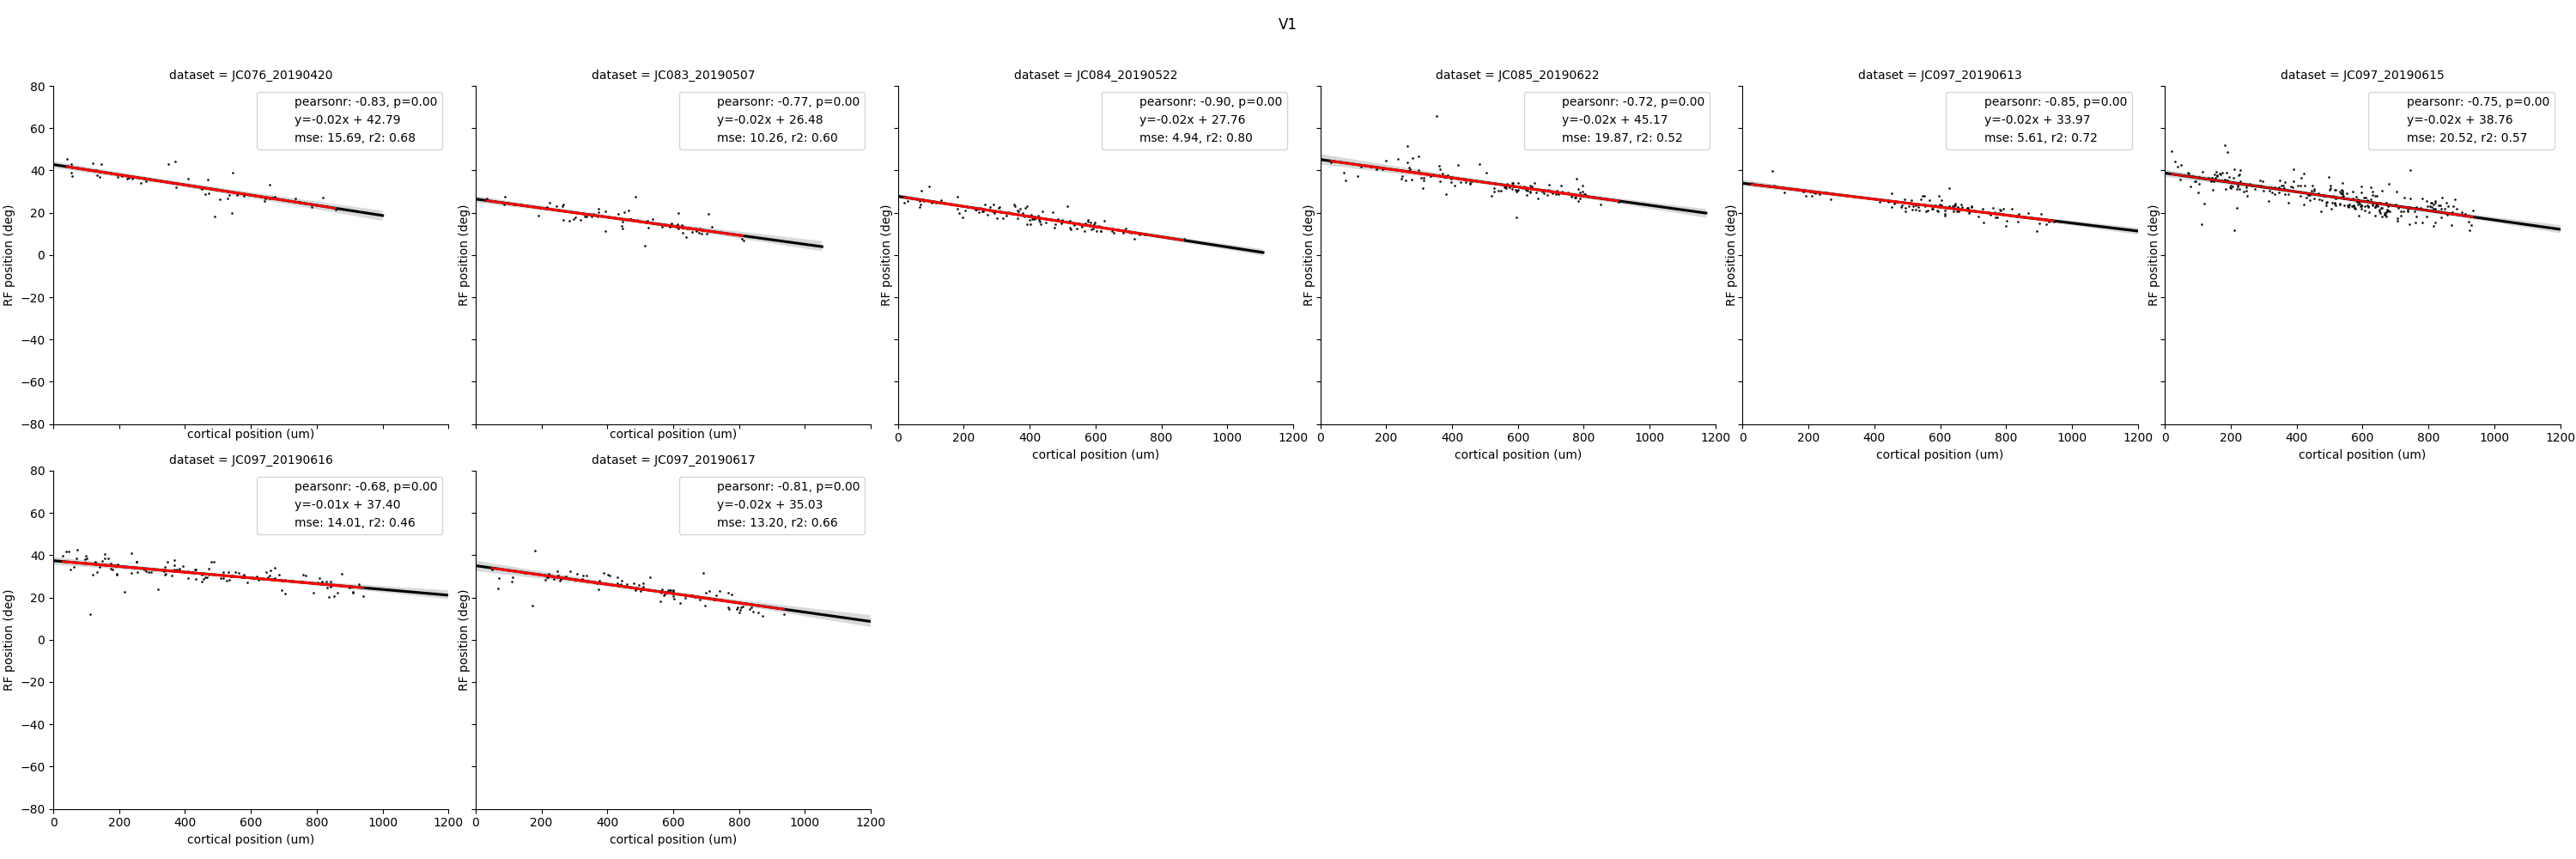

<IPython.core.display.Javascript object>


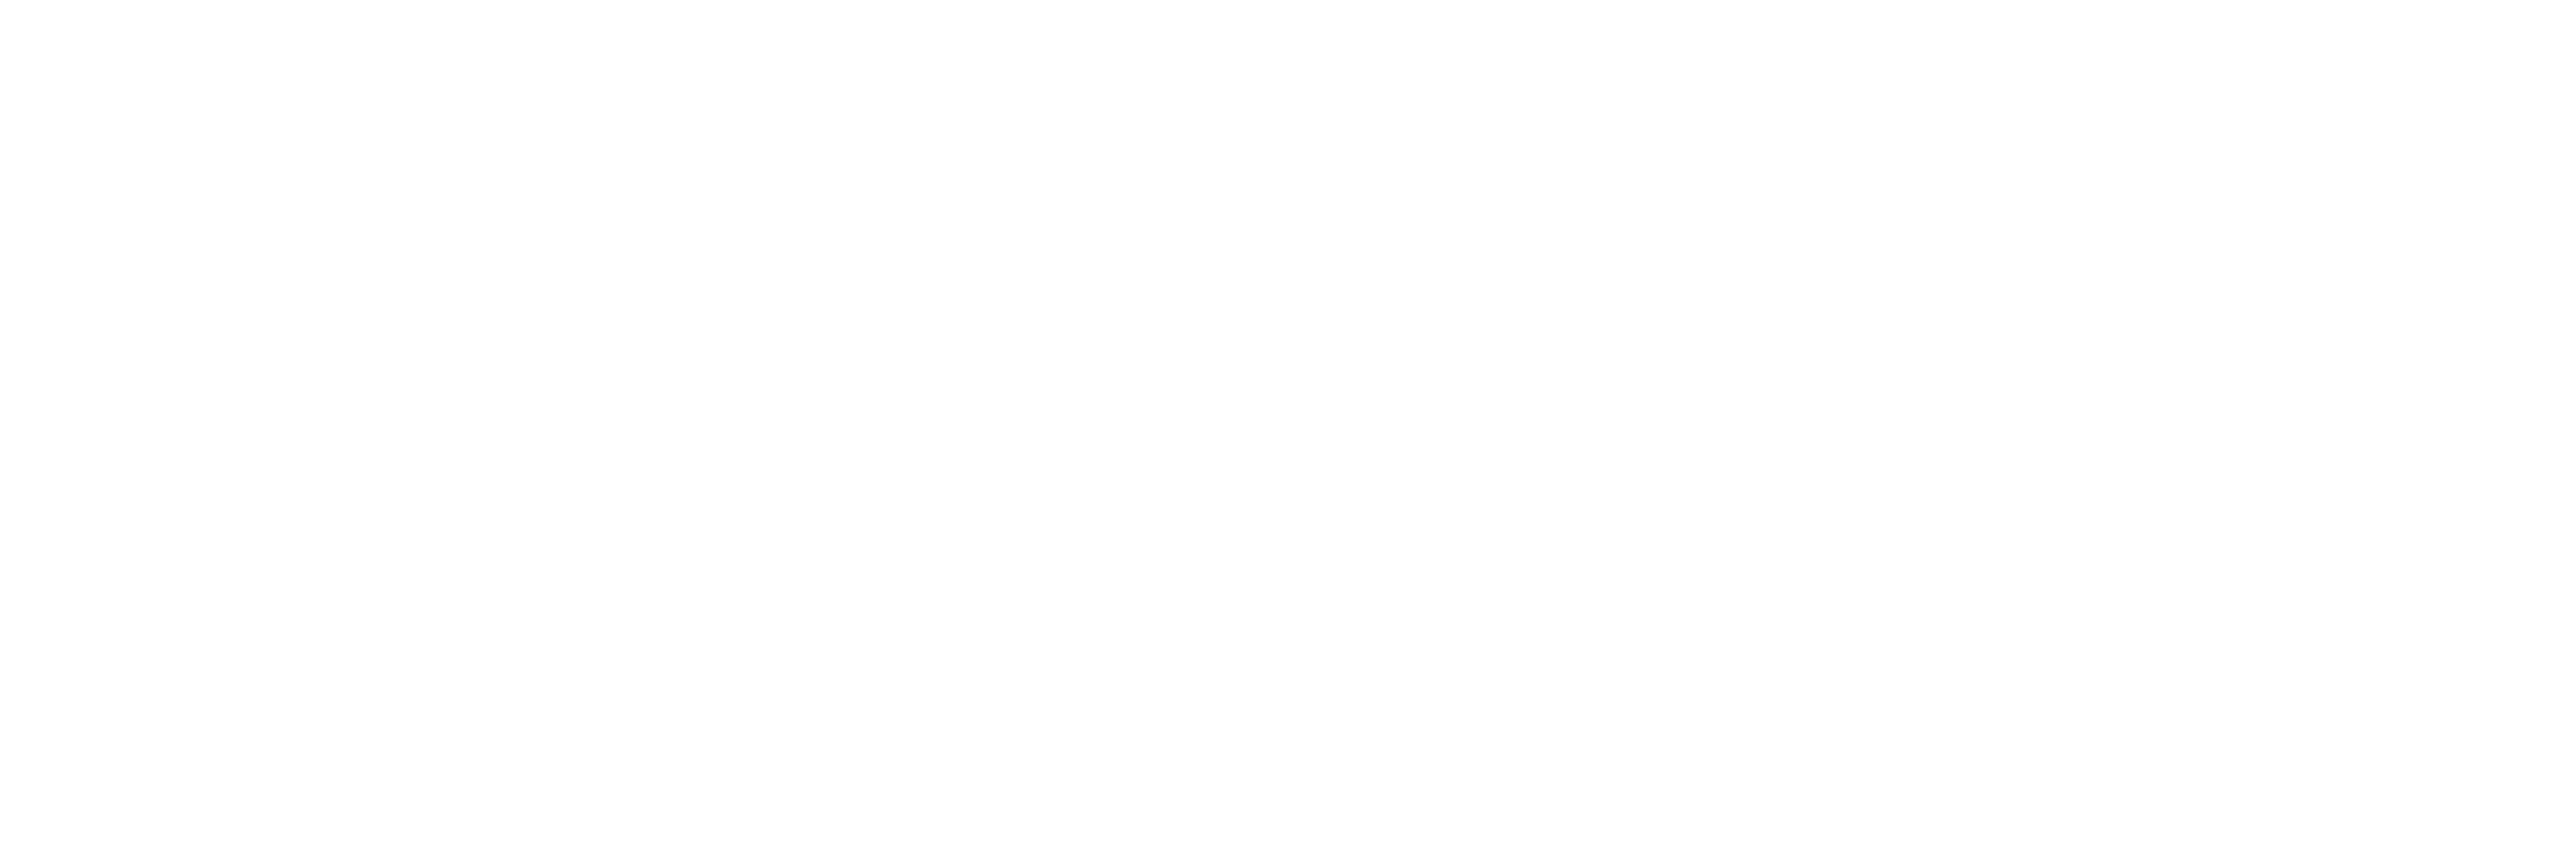

<IPython.core.display.Javascript object>


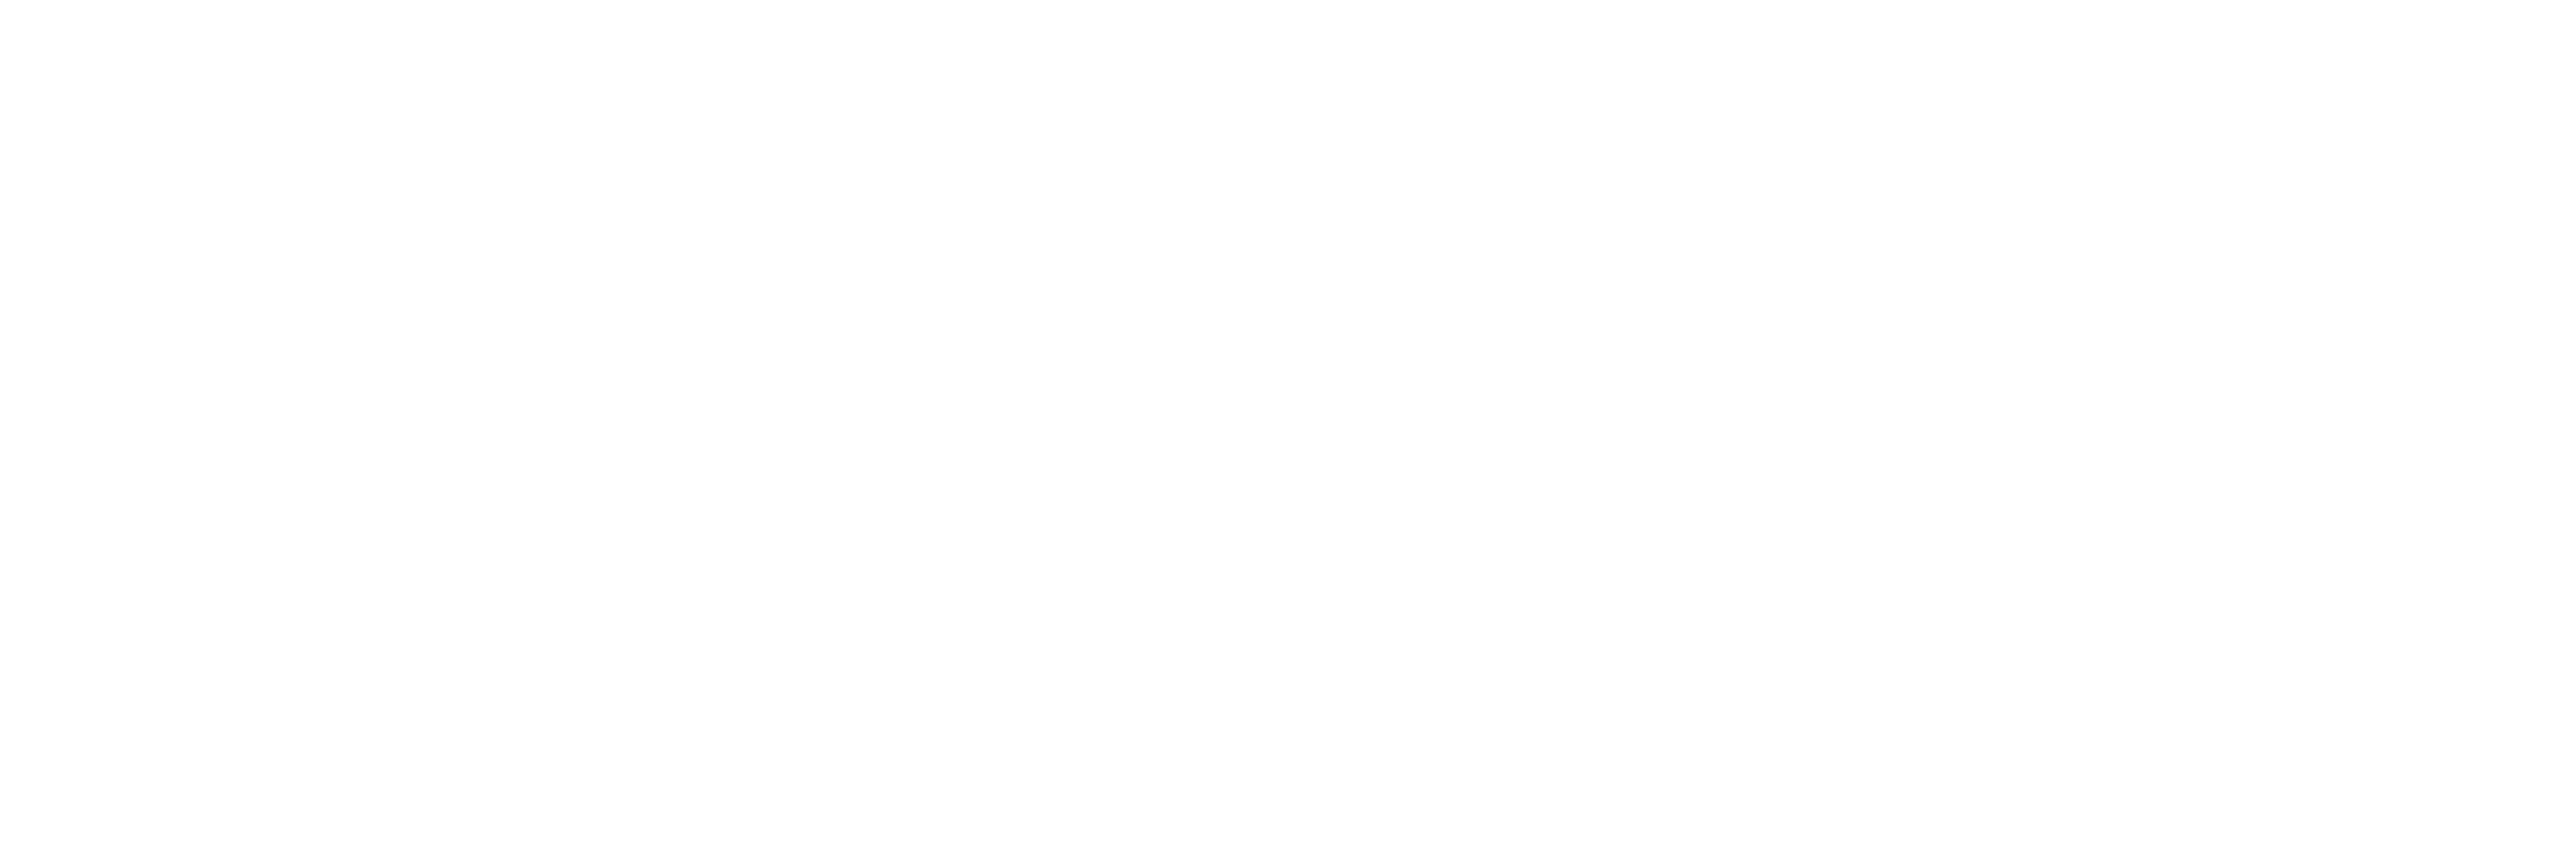

In [72]:

xlabel = 'cortical position (um)' if indep_var == 'fov' else 'RF position (deg)'
ylabel = 'RF position (deg)' if indep_var == 'fov' else 'cortical position (um)'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

axname = 'xpos' if plot_azimuth else 'ypos'

regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = posdf[posdf['visual_area']==visual_area]
    tmpd['dataset'] = ['%s_%s' % (a, s) for a, s, in zip(tmpd['animalid'], tmpd['session'])]

    # Plot regression w/ CI
    g = sns.lmplot('%s_%s' % (axname, indep_var), '%s_%s' % (axname, dep_var), data=tmpd, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)
    
    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, indep_var)]
        yv = tmpd[tmpd['dataset']==curr_dset]['%s_%s' % (axname, dep_var)]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Fit line
        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)
        
        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

        regr_stats.append(pd.Series({'dataset': curr_dset,
                                   'mse': mse,
                                   'slope': float(regr.coef_),
                                   'intercept': float(regr.intercept_),
                                   'r2': r2,
                                     'pearsonr': p,
                                    'visual_area': visual_area}))

    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    figname = '%s-regr-on-%s_%s' % ('azimuth' if plot_azimuth else 'elevation', indep_var, visual_area)
    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))


#### Calculate goodness of fit and aggregate by visual area

In [68]:
def get_regr_stats(xv, yv):
    fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
    mse = skmetrics.mean_squared_error(yv, fitv)
    r2 = skmetrics.r2_score(yv, fitv)
    residuals = yv - fitv
    evfit = pd.Series({#'residuals': yv-fitv,
                          'RMSE': np.sqrt(float(mse)),
                          'R2': float(r2),
                          'slope': float(regr.coef_),
                          'intercept': float(regr.intercept_),
                          'Exp-Var': float(skmetrics.explained_variance_score(yv, fitv)),
                          'MedAE': skmetrics.median_absolute_error(yv, fitv)})
    
    return evfit

In [69]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax


In [70]:

dflist = []
for (visual_area, animalid, session, fov), g in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    tmpevs = []
    xv_az = g['xpos_%s' % indep_var]
    yv_az = g['xpos_%s' % dep_var]

    evfit = get_regr_stats(xv_az, yv_az)
    for c in evfit.index.tolist():
        evfit['%s_az' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    xv_el = g['ypos_%s' % indep_var]
    yv_el = g['ypos_%s' % dep_var]
    evfit = get_regr_stats(xv_el, yv_el)
    for c in evfit.index.tolist():
        evfit['%s_el' % c] = evfit.pop(c)
    tmpevs.append(evfit)
    
    evdf = pd.concat(tmpevs, axis=0)
    evdf['dataset'] = '_'.join([animalid, session])
    evdf['visual_area'] = visual_area

    dflist.append(evdf)

retinostats = pd.concat(dflist, axis=1).T

In [71]:
retinostats.head()

Exp-Var_az MedAE_az     R2_az  RMSE_az intercept_az   slope_az Exp-Var_el  \
0   0.216872  10.6906  0.216872   13.605      12.1651 -0.0303807   0.623921   
1   0.613443  10.7686  0.613443  13.1202     -45.1052  0.0755007  0.0110661   
2   0.177438  7.86615  0.177438   13.605      48.6301 -0.0430867   0.154092   
3   0.380671  4.76435  0.380671  10.9725      53.3614 -0.0575448  0.0136189   
4   0.769928  7.69374  0.769928  12.1054        86.17  -0.126504  0.0291094   

  MedAE_el      R2_el  RMSE_el intercept_el    slope_el         dataset  \
0  2.93271   0.623921  7.41112     -8.17065   0.0332828  JC076_20190502   
1  3.59336  0.0110661  12.1431       7.6203 -0.00908236  JC089_20190522   
2  3.01214   0.154092  6.83784      0.57856  -0.0179948  JC090_20190605   
3  5.23106  0.0136189  7.88947      -7.8349  0.00338153  JC091_20190602   
4  6.52826  0.0291094   8.7944      -9.1818  0.00488823  JC091_20190606   

  visual_area  
0          Li  
1          Li  
2          Li  
3          Li  
4          Li

In [72]:
retinostats['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

#### Plot regression stats by visual area

In [73]:
common_metrics = ['visual_area', 'dataset']
regr_metrics = np.unique([m.split('_')[0] for m in retinostats.columns.tolist() if m not in common_metrics])
print regr_metrics

['Exp-Var' 'MedAE' 'R2' 'RMSE' 'intercept' 'slope']


In [74]:
# Get average of axes
for metric in regr_metrics:
    retinostats[metric] = np.abs(retinostats[['%s_az' % metric, '%s_el' % metric]]).mean(axis=1)



In [75]:
# curr_metrics = regr_metrics.copy()
# curr_metrics = np.append(curr_metrics, common_fields)
# avgmetrics = retinostats[curr_metrics]

exclude=['intercept']
curr_metrics = [m for m in regr_metrics if m not in exclude]


<IPython.core.display.Javascript object>


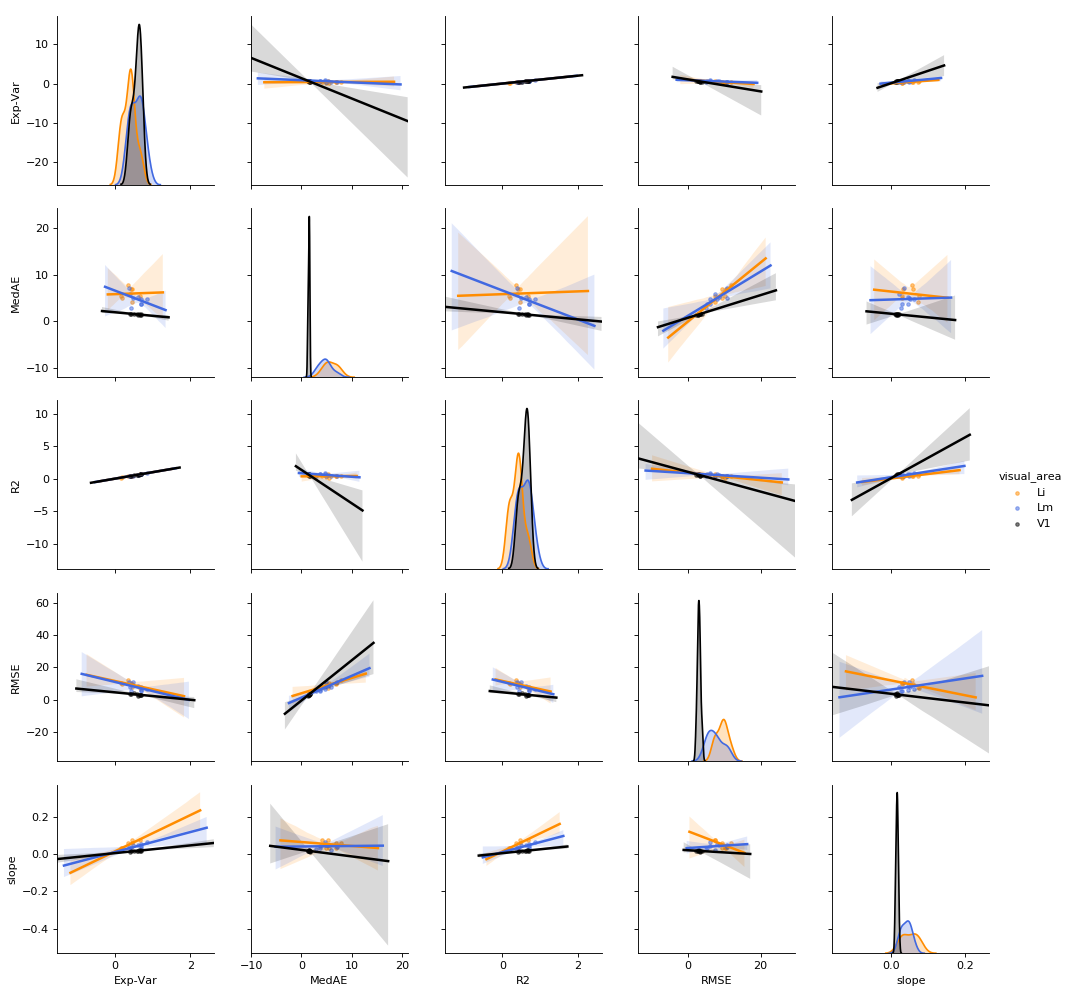

In [58]:
g= sns.pairplot(retinostats, vars=curr_metrics, hue='visual_area', palette=area_colors,
            kind='reg', plot_kws=dict(scatter_kws=dict(s=10, alpha=0.5, linewidth=1)),
            diag_kind='kde') #, diag_kws=dict(histtype='step', normed=False))
g.fig.patch.set_alpha(1)
pl.savefig(os.path.join(retinodir, 'regression-metrics_regr-on-%s.png' % indep_var))

#### Plot subset of summary stats

<IPython.core.display.Javascript object>


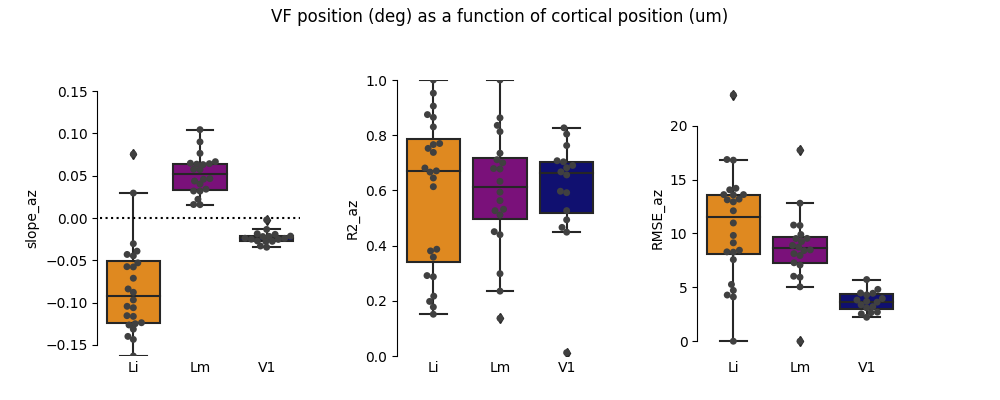

az_stats-regr-on-fov_bmo


In [76]:
plot_azimuth = True

if isinstance(plot_azimuth, bool):
    whichax = 'az' if plot_azimuth else 'el'
else:
    whichax=None

if indep_var == 'fov':
    figtitle = 'VF position (deg) as a function of cortical position (um)'
else:
    figtitle = 'cortical position (um) as a function of VF position (deg)'

fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(retinostats, metric='slope', whichax=whichax, ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(retinostats, metric='R2',  whichax=whichax, ax=axes[1], area_colors=area_colors)
ax3 = boxplot_visual_area(retinostats, metric='RMSE', whichax=whichax, ax=axes[2], area_colors=area_colors)
#ax4 = boxplot_visual_area(retinostats, metric='MedAE', whichax=whichax, ax=axes[3], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle(figtitle)

figname = '%s_stats-regr-on-%s_bmo' % ('bothaxes' if plot_azimuth is None else whichax, indep_var)
pl.savefig(os.path.join(retinodir, '%s.svg' % figname))
print figname

#### Calculate residuals

In [77]:

def calculate_distance(df, indep_var='fov'):
    
    if indep_var=='fov':
        dep_var = 'rf'
    elif indep_var == 'rf':
        dep_var = 'fov'
    
    regr = LinearRegression()
    xv = np.array(df['xpos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['xpos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_az'] = yv - fitv

    mse_az = skmetrics.mean_squared_error(yv, fitv)
    r2_az = skmetrics.r2_score(yv, fitv)
    df['mse_az'] = [mse_az for _ in range(len(fitv))]
    df['r2_az'] = [r2_az for _ in range(len(fitv))]
    
    regr = LinearRegression()
    xv = np.array(df['ypos_%s' % indep_var]).reshape(-1, 1) 
    yv = np.array(df['ypos_%s' % dep_var]).reshape(-1, 1)
    regr.fit(xv, yv)
    fitv = regr.predict(xv)
    df['resid_el'] = yv - fitv
    
    mse_el = skmetrics.mean_squared_error(yv, fitv)
    r2_el = skmetrics.r2_score(yv, fitv) #, multioutput='variance_weighted')
    df['mse_el'] = [mse_el for _ in range(len(fitv))]
    df['r2_el'] = [r2_el for _ in range(len(fitv))]
    
    return df

#### Plot residuals by visual area

In [78]:
print indep_var

fov


In [79]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<IPython.core.display.Javascript object>


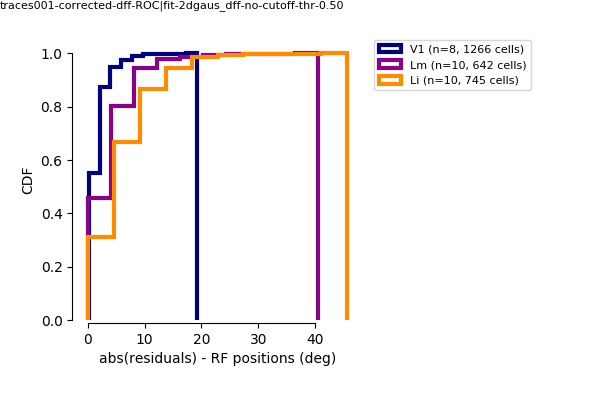

residuals_regr-on-fov_cdf_bmo


In [80]:

cdf = True

xlabel = 'abs(residuals) - RF positions (deg)' if indep_var=='fov' else 'abs(residuals) - FOV position (um)'
ylabel = 'CDF' if cdf else 'fraction'

fig, ax = pl.subplots(figsize=(6,4), sharey=True)
fig.patch.set_alpha(1)
for visual_area in visual_areas:
    nrats = len(pf[pf['visual_area']==visual_area]['animalid'].unique())
    ncells_total = pf[pf['visual_area']==visual_area].shape[0]

    values = abs(pf[pf['visual_area']==visual_area][['resid_el', 'resid_az']]).mean(axis=1).values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i cells)' % (visual_area, nrats, ncells_total),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
figname = 'residuals_regr-on-%s_%s_bmo' % (indep_var, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(retinodir, '%s.png' % figname))
print(figname)

#### Compare metrics (MSE v R2):

<IPython.core.display.Javascript object>


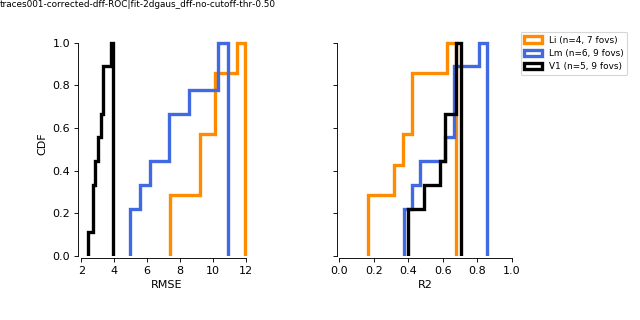

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
cdf = True
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in retinostats.groupby(['visual_area']):
    tmpd['animalid'] = [d.split('_')[0] for d in tmpd['dataset']]
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['dataset'].count()

    metric = 'RMSE'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel(metric)
    ax.set_ylabel('CDF' if cdf else 'fraction')
    
    metric = 'R2'
    values = tmpd[['%s_el' % metric, '%s_az' % metric]].mean(axis=1).values
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

sns.despine(ax=axes[0], trim=True, offset=2)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(retinodir, 'RMSE-R2_regr-on-%s_%s.png' % (indep_var, 'cdf' if cdf else 'hist')))

#### Compare Azimuth v Elevation fits by Visual area

In [52]:
retinostats.head()

Exp-Var_az MedAE_az     R2_az    RMSE_az intercept_az  slope_az Exp-Var_el  \
0   0.216872  10.6906  0.216872  13.605015      12.1651 -0.030381   0.623921   
1   0.177438  7.86615  0.177438  13.605014      48.6301 -0.043087   0.154092   
2   0.380671  4.76435  0.380671  10.972541      53.3614 -0.057545  0.0136189   
3   0.666371  9.39375  0.666371  13.187297      57.0454 -0.106058  0.0589466   
4   0.766051  7.82892  0.766051   9.816790       99.965 -0.123822   0.584473   

  MedAE_el     R2_el    RMSE_el intercept_el  slope_el         dataset  \
0  2.93271  0.623921   7.411116     -8.17065  0.033283  JC076_20190502   
1  3.01214  0.154092   6.837840      0.57856 -0.017995  JC090_20190605   
2  5.23106  0.013619   7.889466      -7.8349  0.003382  JC091_20190602   
3  6.26147  0.058947  10.700957     -6.91977  0.008196  JC091_20190614   
4  2.95629  0.584473   4.929601      12.7476 -0.030948  JC099_20190609   

  visual_area   Exp-Var     MedAE        R2       RMSE  intercept     slope  
0          Li  0.420397  6.811673  0.420397  10.508065  10.167870  0.031832  
1          Li  0.165765  5.439145  0.165765  10.221427  24.604325  0.030541  
2          Li  0.197145  4.997705  0.197145   9.431004  30.598171  0.030463  
3          Li  0.362659  7.827609  0.362659  11.944127  31.982605  0.057127  
4          Li  0.675262  5.392604  0.675262   7.373195  56.356309  0.077385

In [81]:
metric = 'slope'
az_color = 'r'
el_color = 'b'

minv = min([0, tmpd['%s_az' % metric].min(), tmpd['%s_el' % metric].min()])
maxv = round(max([tmpd['%s_az' % metric].max(), tmpd['%s_el' % metric].max()]))

fig, axes = pl.subplots(1,3, figsize=(9,3), sharey=True, sharex=True) 
for ax, visual_area in zip(axes.flat, visual_areas):
    tmpd = retinostats[retinostats['visual_area']==visual_area]
    ax.scatter(np.array(tmpd['%s_az' % metric].values).astype(float), 
               np.array(tmpd['%s_el' % metric].values).astype(float), c='k', alpha=0.5)

    ax.set_title(visual_area)
    ax.axis('equal')
    #ax.set_aspect('equal') #, 'box')
    #ax.set(xlim=(minv, maxv), ylim=(minv, maxv))
    #sns.despine(ax=ax, trim=False, offset=2)
    #ticks = [round(i, 2) for i in np.linspace(minv, maxv, 4)]
    #ax.set_xticks(ticks)

ticks = ax.get_xticks() if ax.get_xticks()[-1] > ax.get_yticks()[-1] else ax.get_yticks()
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.axis('equal')
axes[0].set_xlabel('azimuth')
axes[0].set_ylabel('elevation')

sns.despine(trim=False, offset=2)
#axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(wspace=0.1, top=0.8, left=0.1, right=0.9, bottom=0.2)
fig.suptitle(metric)


NameError: name 'tmpd' is not defined

# Pairwise distances

In [54]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')

#### Create output dir

In [82]:
pairwisedir = os.path.join(rfdir, 'pairwise-distances')
if not os.path.exists(pairwisedir):
    os.makedirs(pairwisedir)
print("Saving pairwise-distance analysis to: %s" % pairwisedir)

Saving pairwise-distance analysis to: /n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff/pairwise-distances


#### Look at PW distances of by dataset

In [83]:
# Create subdir
curr_sessiondir = os.path.join(pairwisedir, 'sessions')
if not os.path.exists(curr_sessiondir):
    os.makedirs(curr_sessiondir)

In [84]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0    5.0    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1    7.0    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2   24.0    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3   25.0    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4   26.0    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

In [85]:
pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
                for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# SPLIT pw-dists

# Split PW dist calculation by azimuth/elevation

In [86]:
import itertools

testdf = pd.DataFrame({0: np.linspace(0, 10, 10)})
                      
#[i-v for (i, v) in itertools.product(testdf.values, testdf.values)]


In [87]:
tmpd = pf[pf['visual_area']==visual_area]

# Get all pairwise distances for each fov:
tmpd_list = []
for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
    cdists = g['%s_%s' % (axname, indep_var)].values
    #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
    pwdiffs_ind = [t1-t2 for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]
    
    rdists = g['%s_%s' % (axname, dep_var)].values
    #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
    pwdiffs_dep = [t1-t2 for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]
    
    assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"
             
    tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                        '%s distance' % dep_var: pwdiffs_dep,
                        'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
    tmpd_list.append(tmpd)
pw = pd.concat(tmpd_list, axis=0)

# Plot regression w/ CI
g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)


NameError: name 'axname' is not defined

In [88]:
plot_azimuth= True

<IPython.core.display.Javascript object>


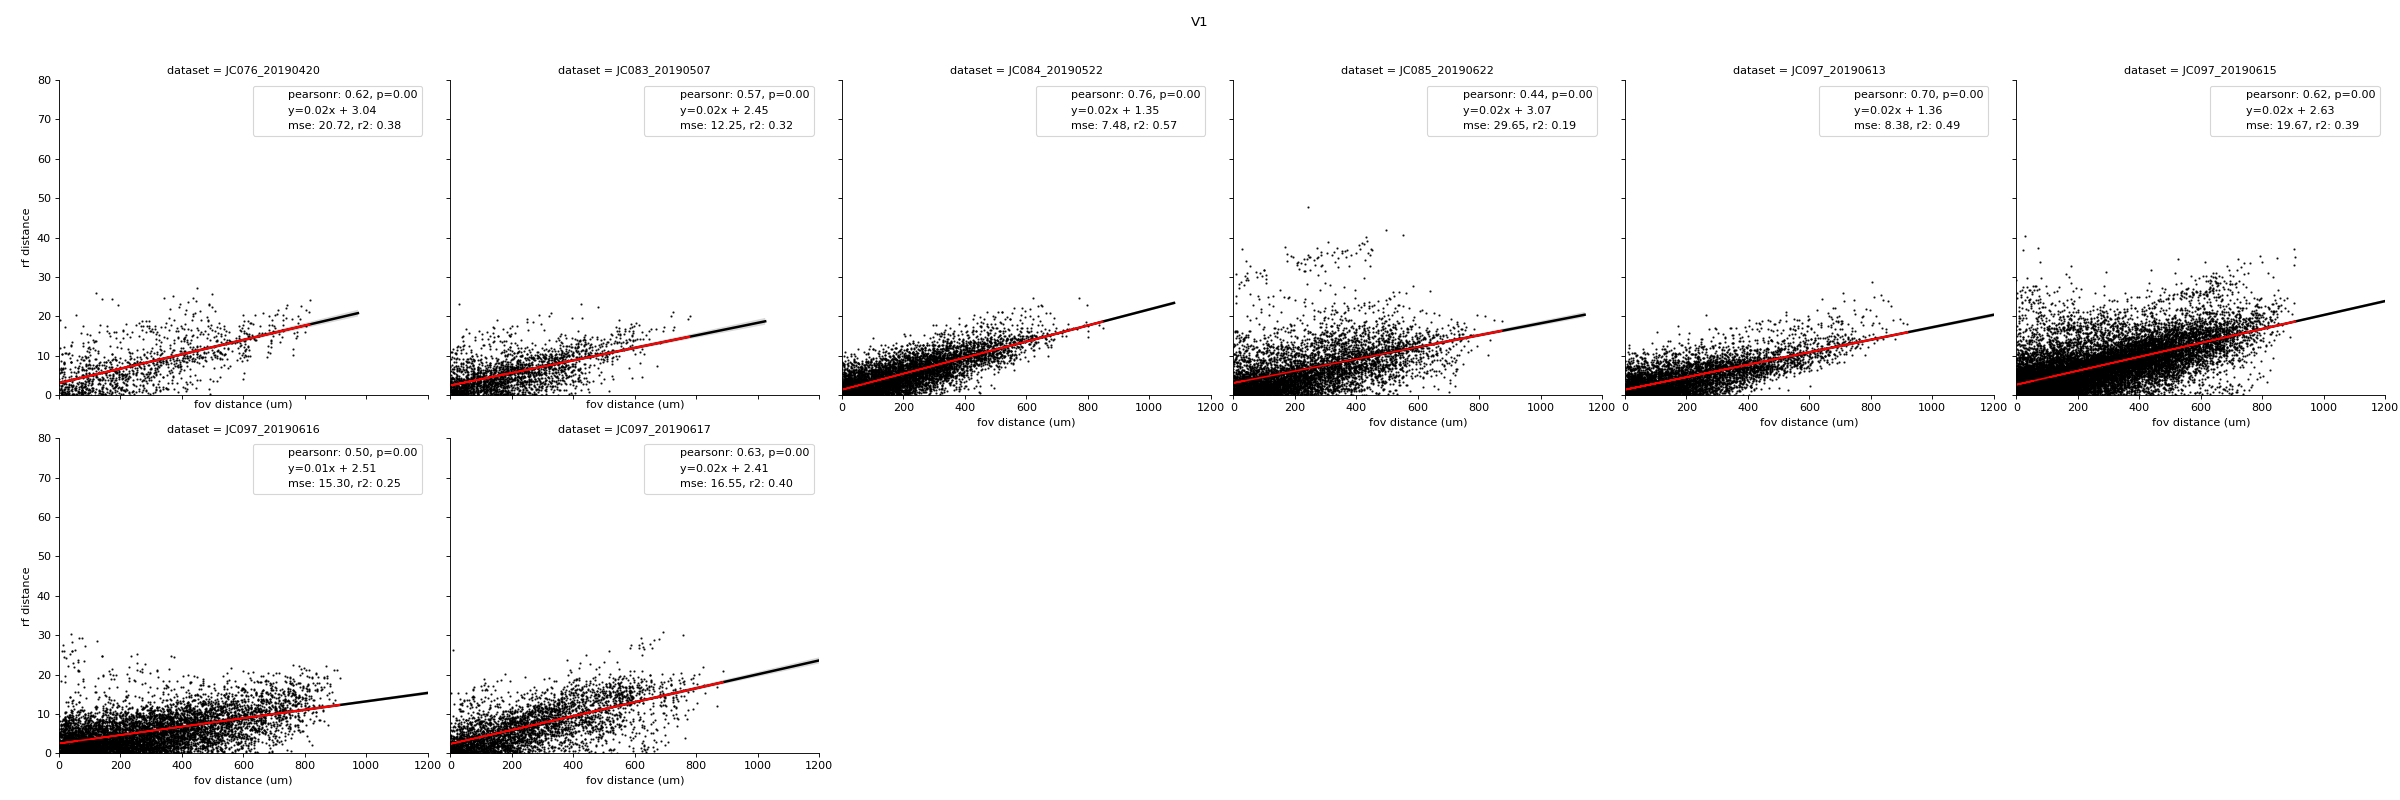

<IPython.core.display.Javascript object>


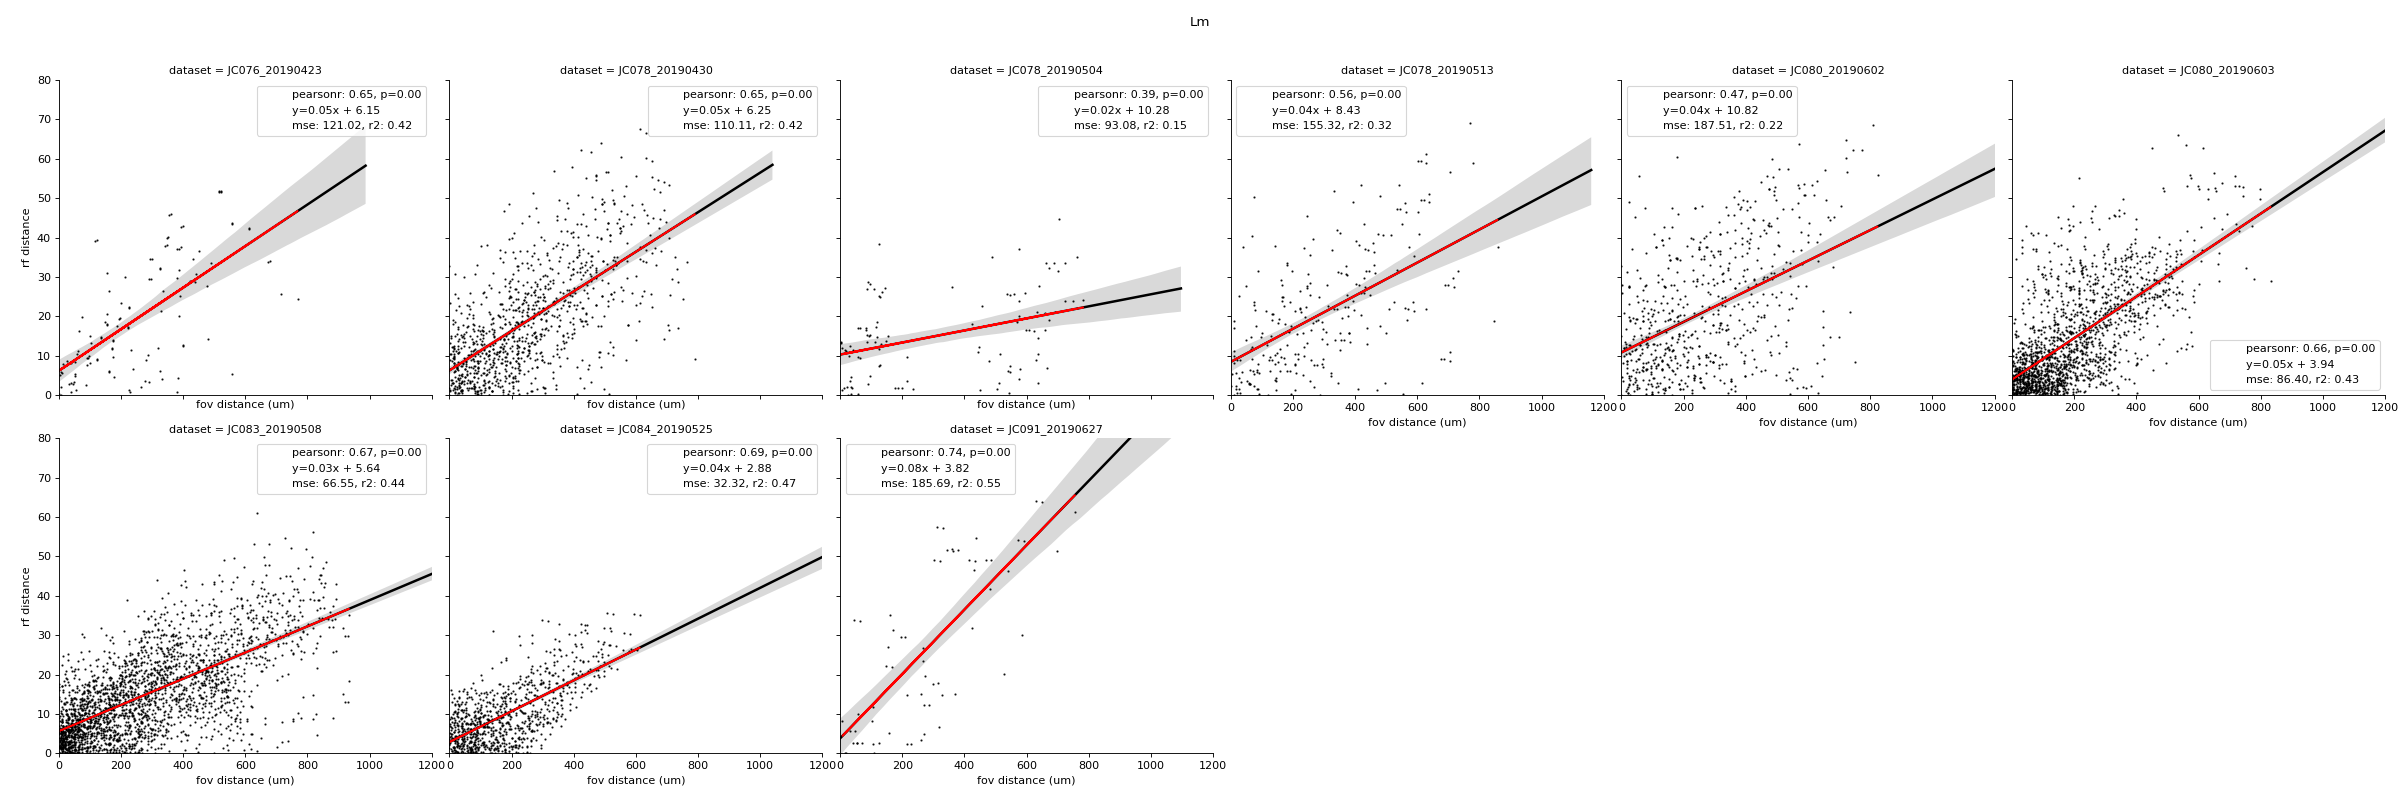

<IPython.core.display.Javascript object>


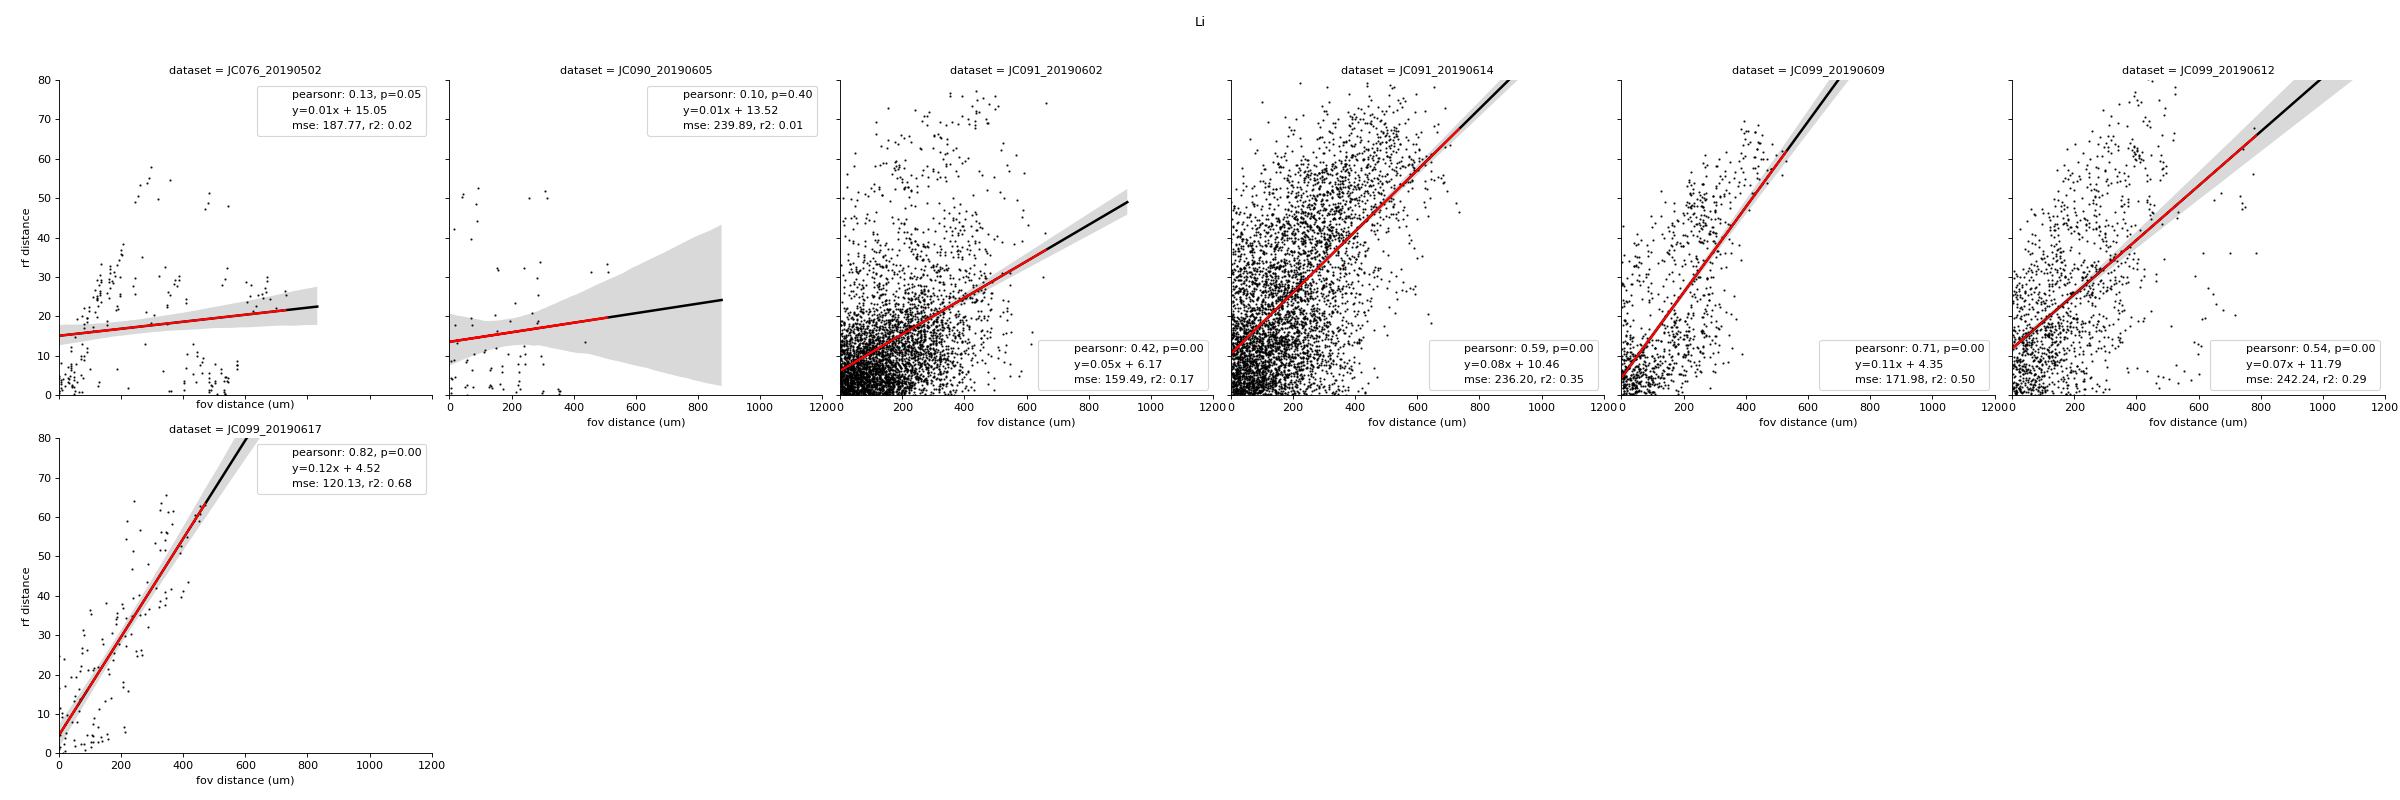

In [130]:
dep_var = 'rf' if indep_var=='fov' else 'fov'
axname = 'xpos' if plot_azimuth else 'ypos'

plot_str = 'azimuth' if plot_azimuth else 'elevation'
xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200

curr_color = az_color if plot_azimuth else el_color

# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = g['%s_%s' % (axname, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = [ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]]

        rdists = g['%s_%s' % (axname, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = [ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]]

        assert len(pwdiffs_ind)==len(pwdiffs_dep), "UNEVEN"

        tmpd = pd.DataFrame({'%s distance' % indep_var: pwdiffs_ind,
                            '%s distance' % dep_var: pwdiffs_dep,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(pwdiffs_dep))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)


    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, curr_color)
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([0, xmax])
        ax.set_ylim([0, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, '%s-only_regr-on-%s_%s.png' % (plot_str, visual_area, indep_var)))


In [89]:
curr_sessiondir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/fit-2dgaus_dff-no-cutoff/pairwise-distances/sessions'

### Get stats for PW dists split by el, az

In [90]:
pwdiffs_ind

NameError: name 'pwdiffs_ind' is not defined

In [91]:

pwstats_split = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    for axn in ['xpos', 'ypos']:

        # Get all pairwise distances for current fov:
        cdists = g['%s_%s' % (axn, indep_var)].values
        #pwdiffs_ind = [i-v for (i, v) in itertools.product(cdists.values, cdists.values)]
        pwdiffs_ind = np.array([ np.abs(t1-t2) for i, t1 in enumerate(cdists) for t2 in cdists[i + 1:]])

        rdists = g['%s_%s' % (axn, dep_var)].values
        #pwdiffs_dep = [i-v for (i, v) in itertools.product(rdists.values, rdists.values)]
        pwdiffs_dep = np.array([ np.abs(t1-t2) for i, t1 in enumerate(rdists) for t2 in rdists[i + 1:]])


        # Get linear fit:
        fitdist, regr = fit_linear_regr(pwdiffs_ind, pwdiffs_dep, return_regr=True)
        mse = skmetrics.mean_squared_error(pwdiffs_dep, fitdist)
        r2 = skmetrics.r2_score(pwdiffs_dep, fitdist)
        res = pd.Series({'visual_area': visual_area,
                             'animalid': animalid,
                             'session': session,
                             'fov': fov,
                             'RMSE': np.sqrt(mse),
                             'R2': r2,
                             'slope': float(regr.coef_),
                             'intercept': float(regr.intercept_),
                             'axis': axn,
                             'dataset': '_'.join([animalid, session, fov])})
        pwstats_split.append(res)

pwstats_split = pd.concat(pwstats_split, axis=1).T

In [93]:
g.shape

(59, 15)

In [94]:
len(pwdiffs_dep)

1711

In [92]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

#### Plot PW stts for SPLITs

<IPython.core.display.Javascript object>


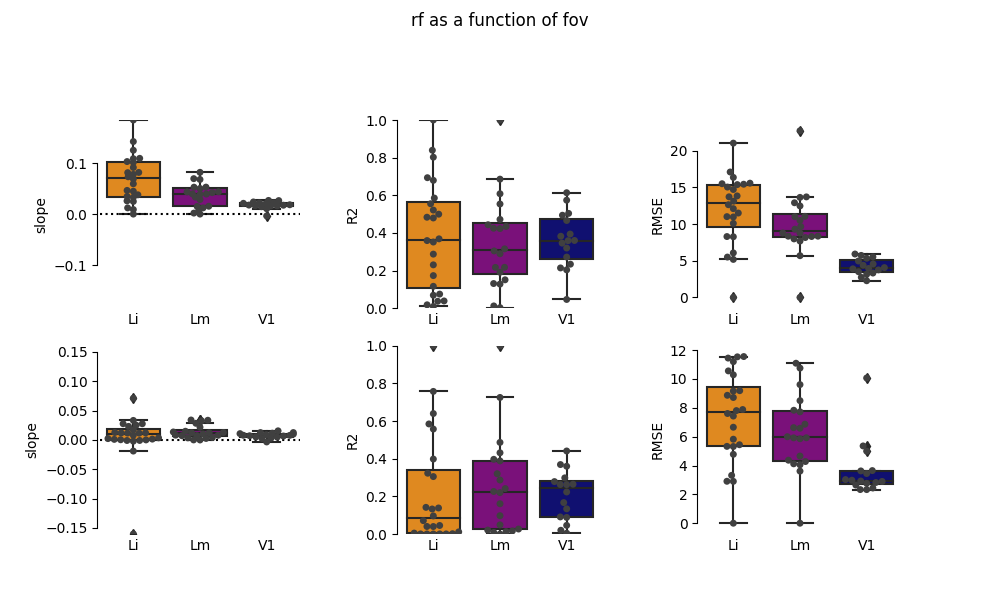

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
fig, axes = pl.subplots(2, 3, figsize=(10,6))
fig.patch.set_alpha(1)

for ai, axn in enumerate(['xpos', 'ypos']):
    curr_pwstats = pwstats_split.groupby(['axis']).get_group(axn)

    ax1 = boxplot_visual_area(curr_pwstats, metric='slope', ax=axes[ai, 0], area_colors=area_colors)

    ax2 = boxplot_visual_area(curr_pwstats, metric='R2', ax=axes[ai, 1], area_colors=area_colors)

    ax3 = boxplot_visual_area(curr_pwstats, metric='RMSE', ax=axes[ai, 2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'split-axes_stats-regr-on-%s_bmo.svg' % indep_var))

In [96]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax



#### PW dists, split:  Plot slope for Az and El on same 

In [97]:
axdf.groupby(['visual_area'])['slope'].apply(np.mean)

NameError: name 'axdf' is not defined

<IPython.core.display.Javascript object>


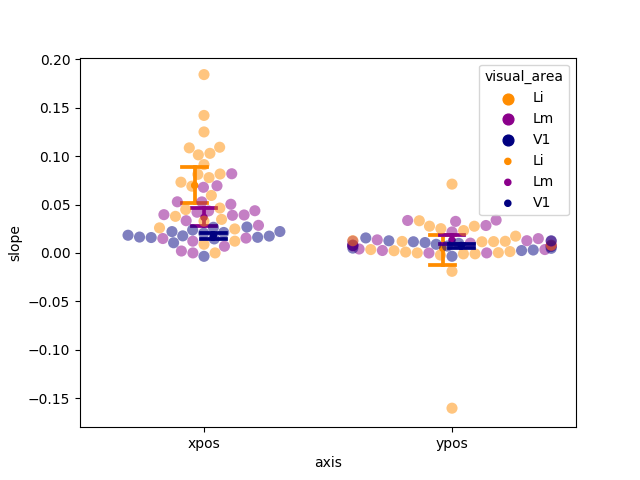

In [98]:
fig, ax = pl.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([0, 0],[0, 0], marker='s')
b = ax.scatter([0, 0],[0, 0], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="axis", y="slope", hue="visual_area",data=pwstats_split, 
                   palette=area_colors,size=8,ax=ax, dodge=False, alpha=0.5,facecolor='none')
N_hues = len(pd.unique(pwstats_split.visual_area))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
#update legend
ax.legend(c[-3:],pd.unique(pwstats_split.visual_area))


mvs = pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)

sns.pointplot(x='axis', y='slope', hue='visual_area', data=pwstats_split, ci=95, capsize=0.1,
             palette=area_colors, dodge=True, apha=0.7, markers='.', join=False)


In [185]:
pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)


axis  visual_area
xpos  Li             0.063929
      Lm             0.045119
      V1             0.016610
ypos  Li             0.009870
      Lm             0.020191
      V1             0.009434
Name: slope, dtype: float64

In [99]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

<IPython.core.display.Javascript object>


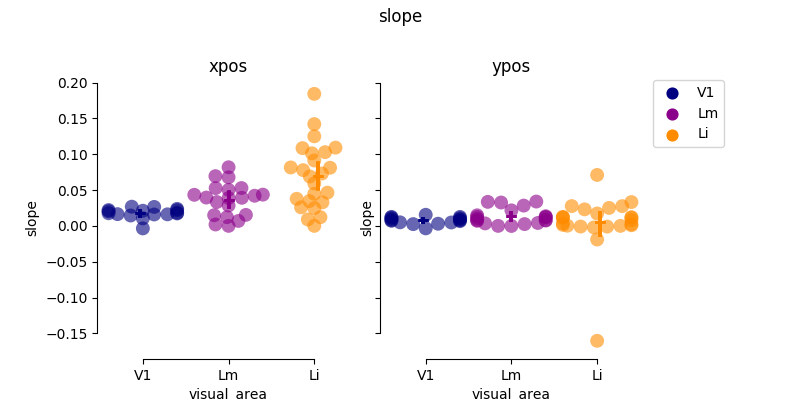

In [100]:

metric = 'slope'
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

for ax, axn in zip(axes.flat, ['xpos', 'ypos']):
    axdf = pwstats_split[pwstats_split['axis']==axn]
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

       # ax.plot(ai, mval, color=area_colors[visual_area], marker='_', markersize=30)
        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axn)
    if axn == 'xpos':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8)
fig.suptitle(metric)

pl.savefig(os.path.join(pairwisedir, '%s_pw-dists_ax-v-el_bmo.svg' % metric))


In [141]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

# Combine axes: PW distance regression for each dataset for each visual area

In [79]:
indep_var

'fov'

<IPython.core.display.Javascript object>


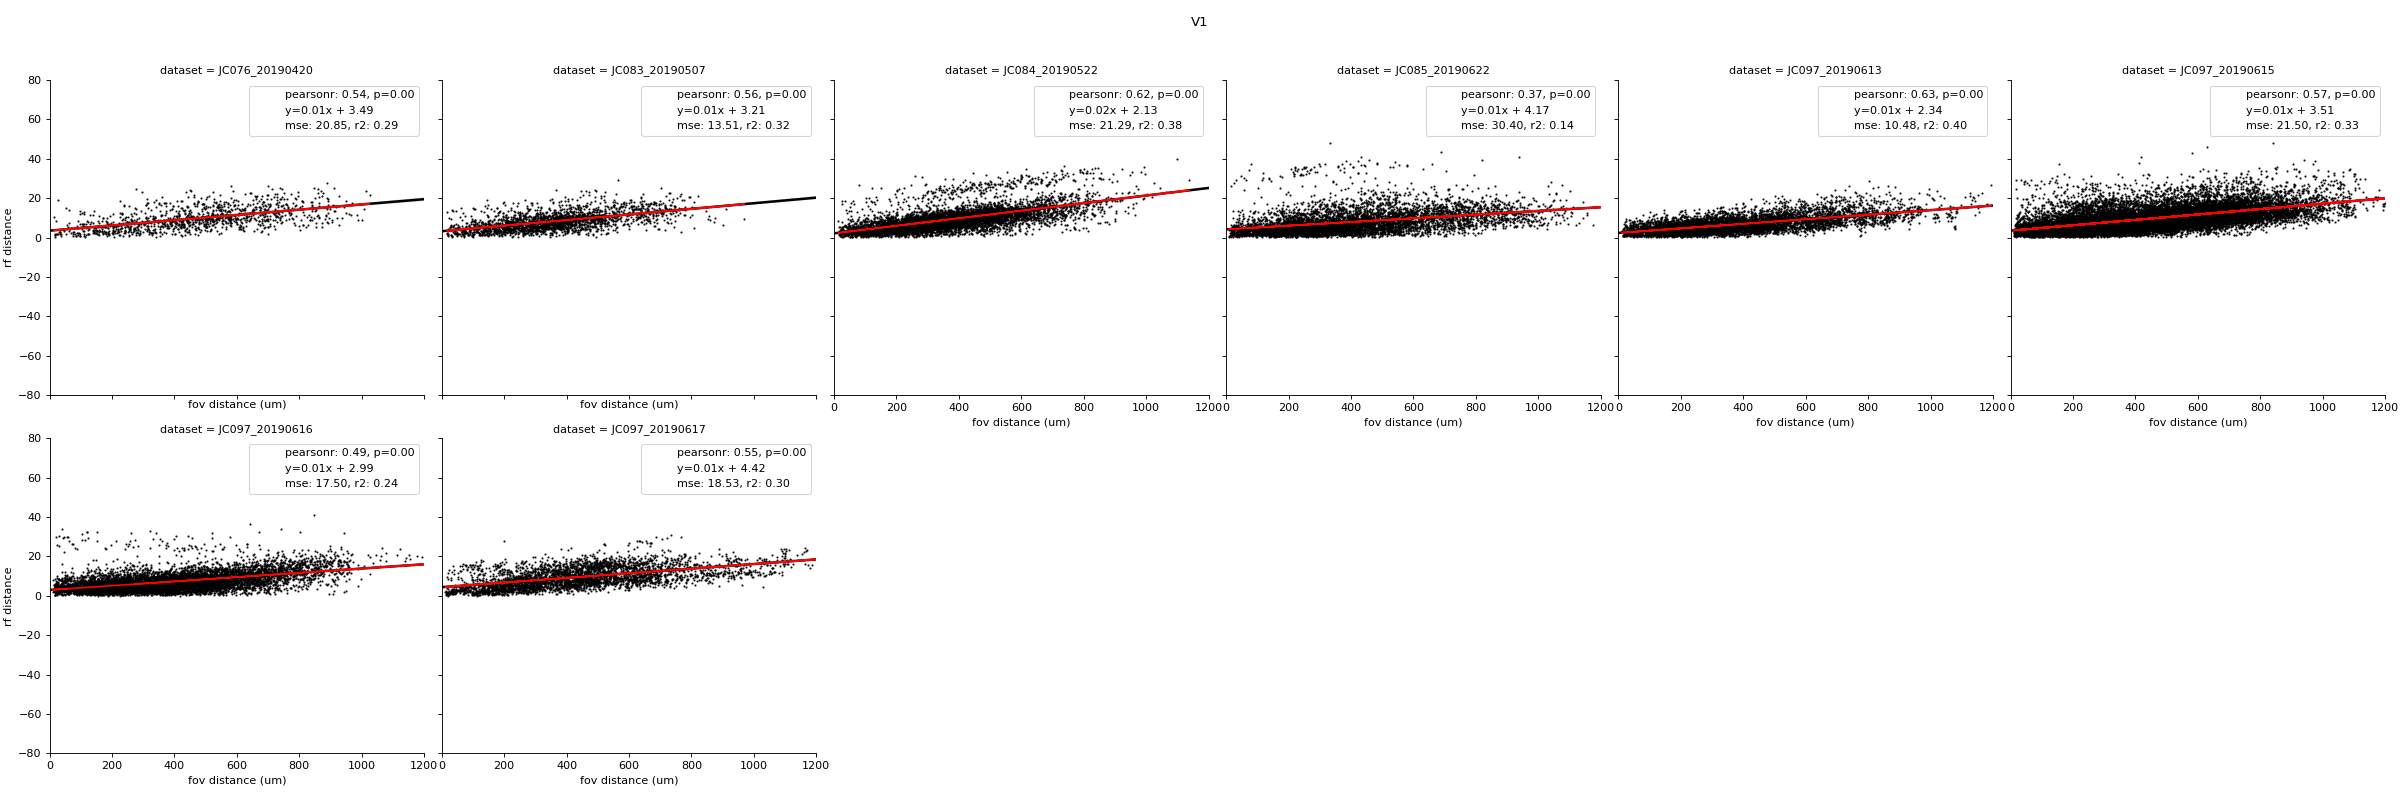

<IPython.core.display.Javascript object>


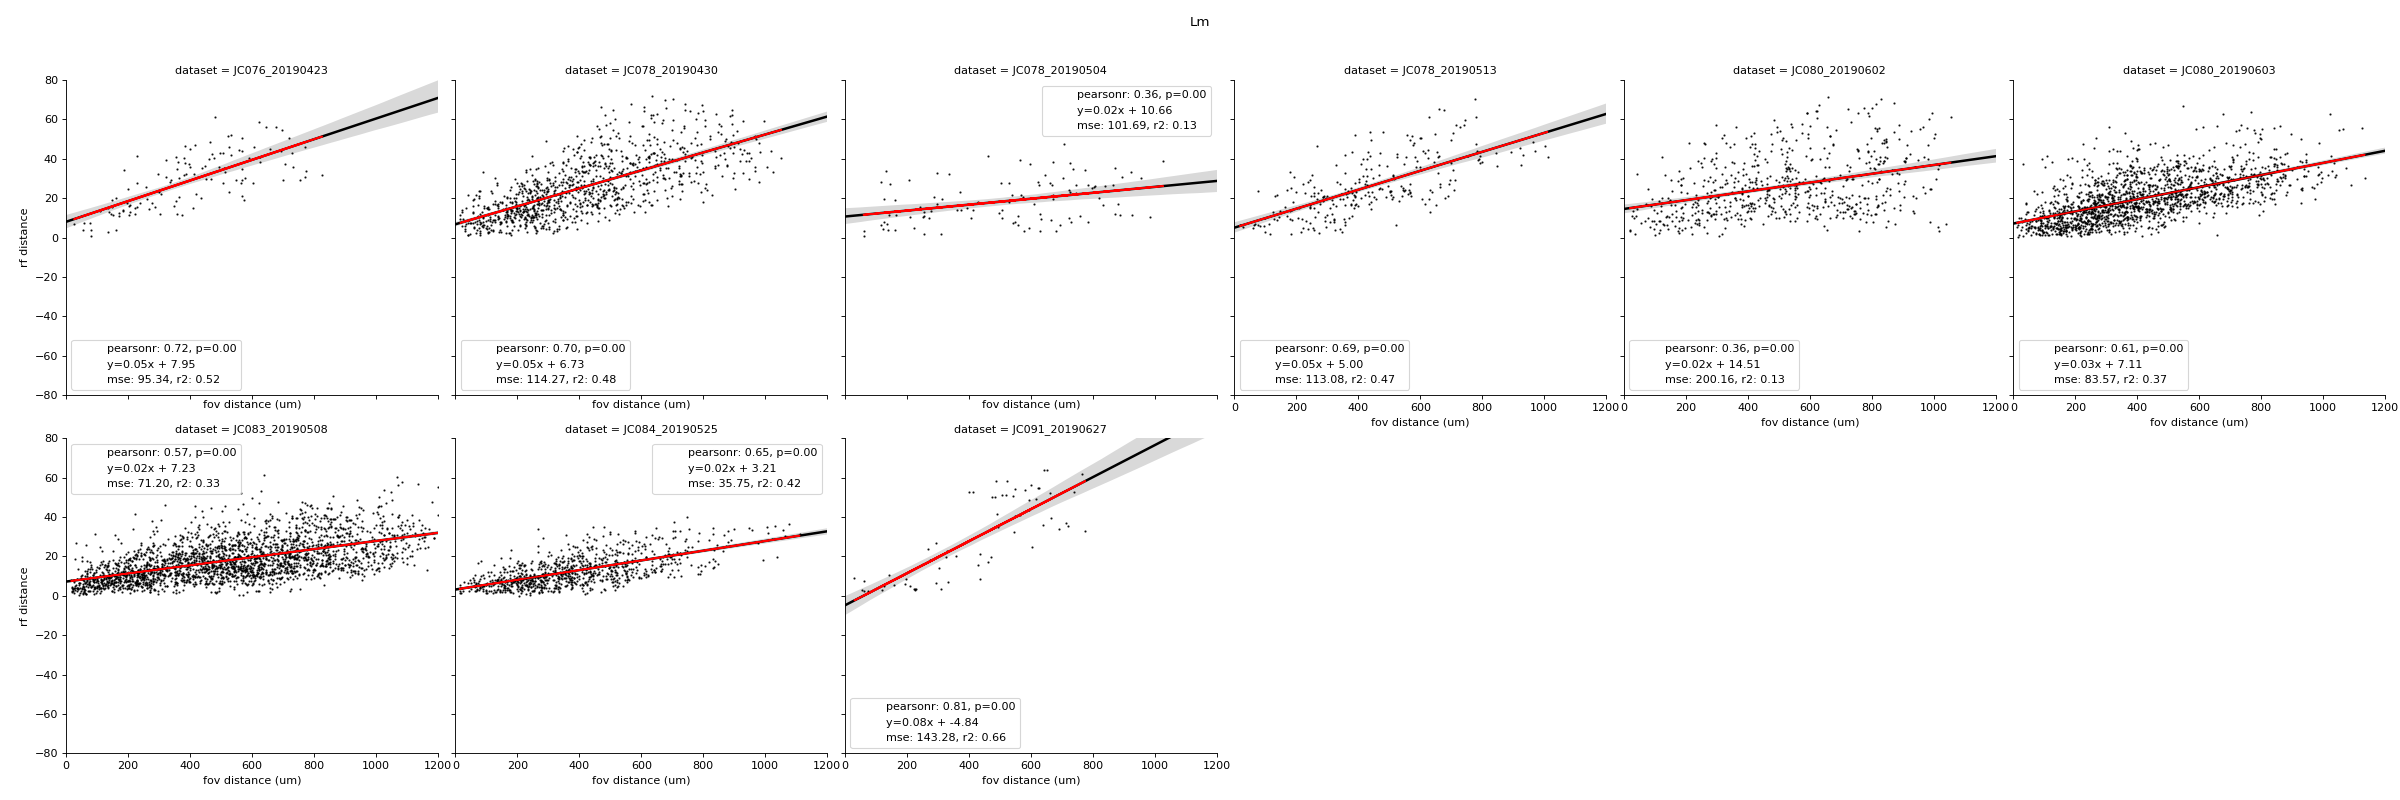

<IPython.core.display.Javascript object>


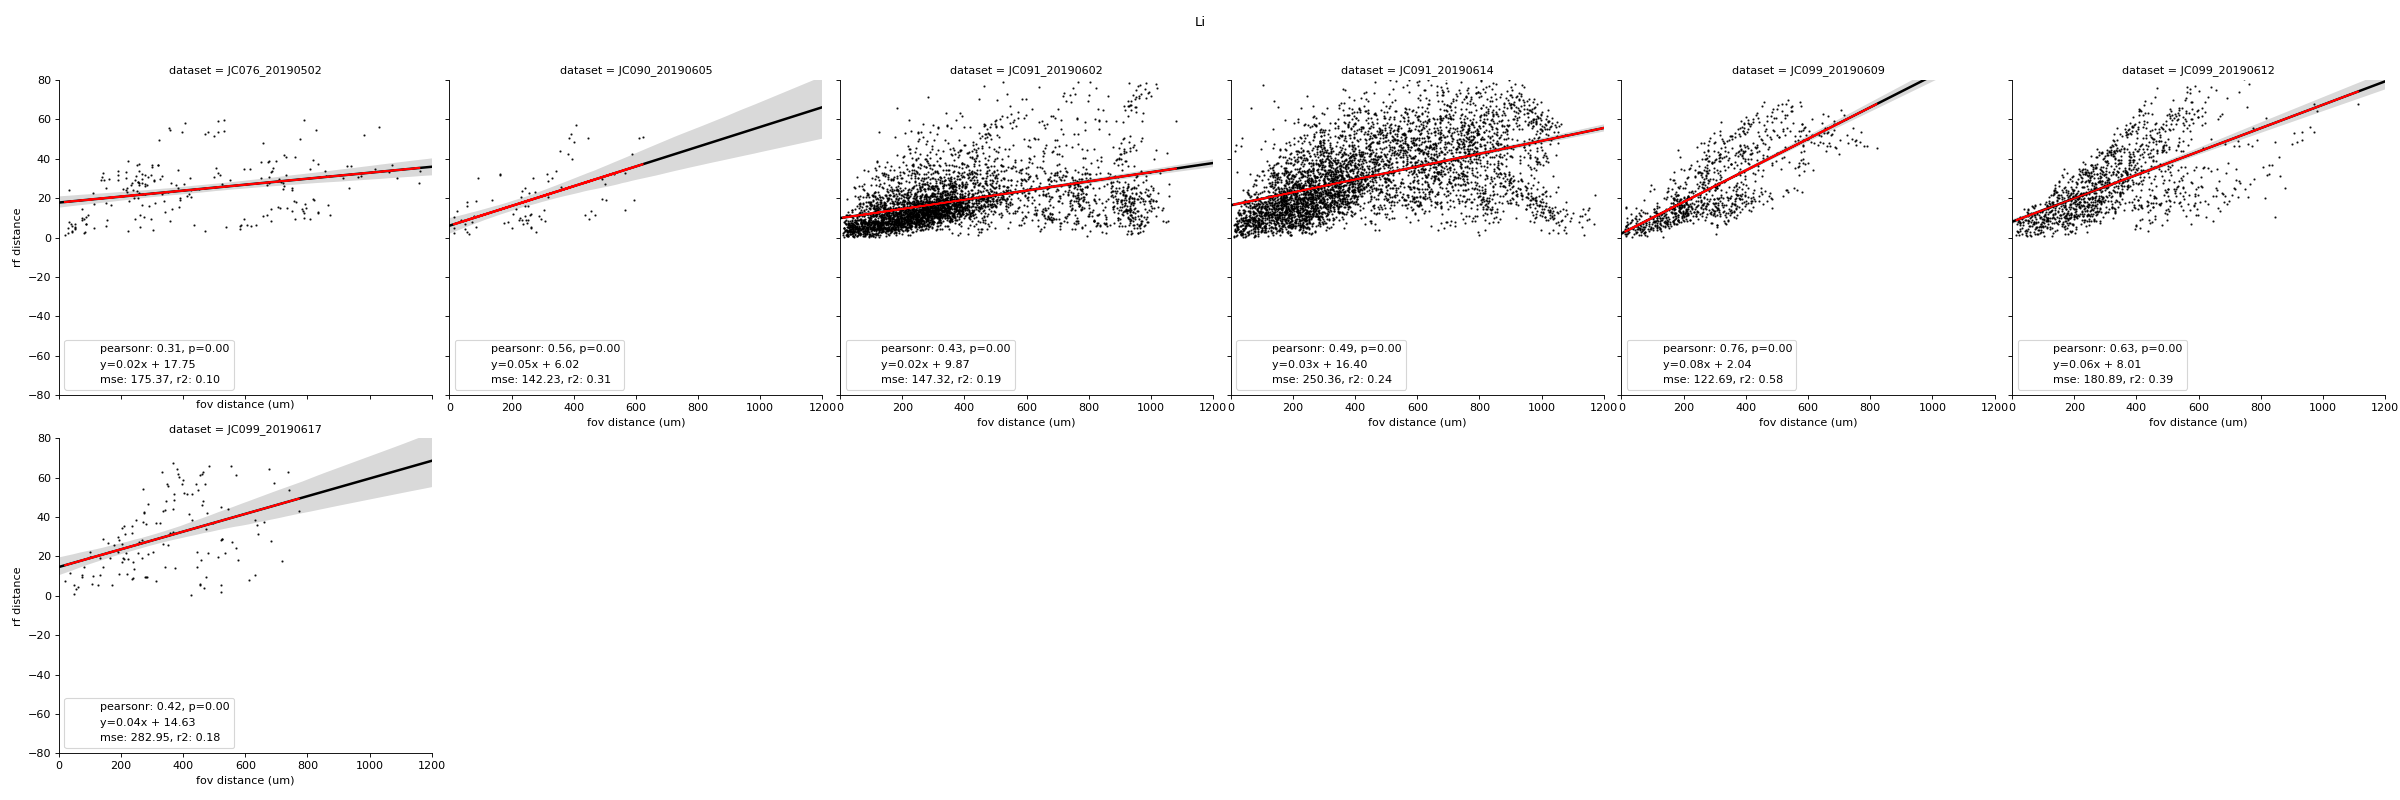

In [84]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200


# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

R2     RMSE         dataset intercept       slope visual_area
0  0.291849   4.5666  JC076_20190420   3.49435   0.0133151          V1
1  0.110722  6.13418  JC076_20190501   6.32593  0.00917705          V1
2  0.317121  3.67584  JC083_20190507   3.21438   0.0141987          V1
3  0.177895  5.95603  JC083_20190510     5.859   0.0142868          V1
4   0.39773  3.88048  JC083_20190511   2.64958   0.0186305          V1

In [96]:
del reginfo

In [85]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [86]:
pwstats.head()

R2     RMSE animalid                       dataset            fov  \
0  0.0953611  13.2428    JC076  JC076_20190502_FOV1_zoom2p0x  FOV1_zoom2p0x   
1    0.31371  11.9261    JC090  JC090_20190605_FOV1_zoom2p0x  FOV1_zoom2p0x   
2   0.186778  12.1375    JC091  JC091_20190602_FOV1_zoom2p0x  FOV1_zoom2p0x   
3   0.243542  15.8227    JC091  JC091_20190614_FOV1_zoom2p0x  FOV1_zoom2p0x   
4   0.584282  11.0767    JC099  JC099_20190609_FOV1_zoom2p0x  FOV1_zoom2p0x   

  intercept   session      slope visual_area  
0   17.7525  20190502  0.0151595          Li  
1   6.01845  20190605  0.0501515          Li  
2   9.86805  20190602  0.0233078          Li  
3   16.3973  20190614  0.0326908          Li  
4   2.04233  20190609  0.0800883          Li

<IPython.core.display.Javascript object>


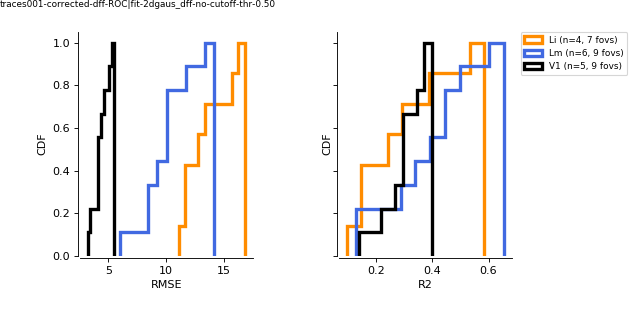

In [87]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


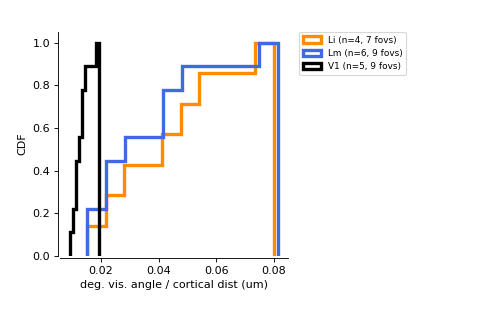

In [88]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


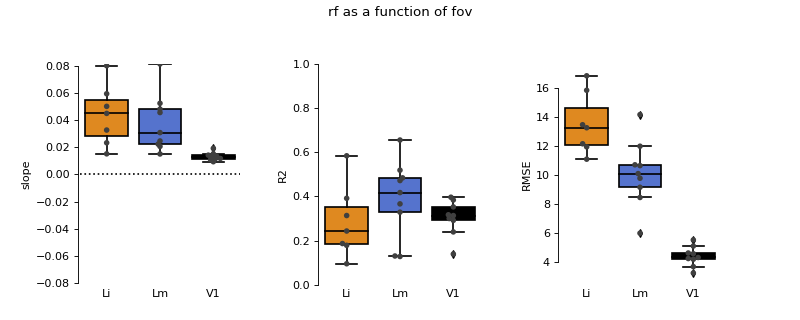

In [89]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

<IPython.core.display.Javascript object>


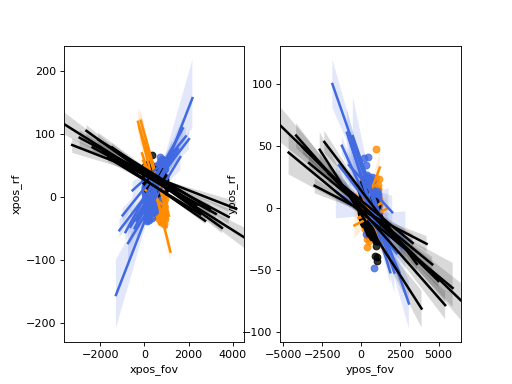

In [90]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [199]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    S = util.Session(animalid, session, fov)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC076|20190502] No experiment exists for: gratings
Stimuli presented at coords: (-5, 8)
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: com

... Getting screen info
... [JC080|20190506|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC080|20190506] No experiment exists for: gratings
Stimuli presented at coords: (15, 8)
[JC080] 20190602 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC080|20190602] No experiment exists for: blobs
[JC080|20190602] No experiment exists for: gratings
[JC080] 20190603 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC080|20190603|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC080|20190603|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings


... ... combined_gratings_static
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (25, 5)
[JC097] 20190615 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190615 - FOV2_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
[JC097|20190615] No experiment exists for: blobs
[JC097|20190615] No experiment exists for: gratings
[JC097] 20190616 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... ... combined_blobs_static
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC097|20190616|FOV1_zoom2p0x] creating grati

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

r2    sigma_x    sigma_y     theta         x0         y0   cell  \
0    0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018    0.0   
1    0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950    2.0   
2    0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272    5.0   
3    0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018    9.0   
4    0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   11.0   
5    0.749326  24.060205  17.826767 -0.540785  21.079350 -12.622418   12.0   
6    0.855683  30.551514  22.742899 -0.194002  24.359459 -15.700910   17.0   
7    0.696656  27.990076  23.843953  0.069130  25.972457 -13.935280   18.0   
8    0.768487  21.792108  20.778926  0.133244  24.595777 -15.828255   19.0   
9    0.647991  19.231749  23.597969  7.482864  24.647061 -14.644582   20.0   
10   0.664964  28.485420  23.327092 -0.165733  22.522499 -13.689643   21.0   
11   0.697408  37.220701  20.067509 -0.538142  25.617105 -14.165844   23.0   
12   0.830778  28.052161  22.851207  0.019171  23.959988 -18.060165   25.0   
13   0.659888  24.684523  22.871740 -0.110131  25.477272 -14.224848   26.0   
14   0.706372  32.309309  21.921249 -3.626894  24.790675 -15.134649   27.0   
15   0.771317   6.238730   6.857521  2.065690  19.994226 -19.770466   29.0   
16   0.528987  13.406842  11.629828 -2.447291  27.486044 -15.949036   30.0   
17   0.838610  18.920871  15.368178 -6.821364  25.340041 -17.589140   33.0   
18   0.758682  25.043465  28.017584  0.173640  26.432311 -20.467824   35.0   
19   0.842691  17.751149  33.932036  0.535572  30.602510 -26.987631   36.0   
20   0.623137  39.765831  24.771200 -0.669511  22.286065 -18.509528   41.0   
21   0.618670  35.668650  19.654706 -0.137295  20.236856 -13.920210   43.0   
22   0.580811  15.462046  12.018522  1.919947  21.389652 -17.079508   46.0   
23   0.802064  27.752021  20.591647 -0.668535  20.685405 -13.793877   51.0   
24   0.871361  14.736783  11.827486 -0.605707  20.827247 -19.105224   55.0   
25   0.922144  17.177681  26.224431  0.493811  21.744589 -22.958313   56.0   
26   0.871618  16.521106  23.569554  0.764062  22.413474 -18.922926   57.0   
27   0.891020  14.663139  17.637268  1.201600  24.708676 -18.084358   61.0   
28   0.686160  21.183891  16.435022 -0.022699  20.866747 -21.480730   63.0   
29   0.844889  22.705430  32.684764  0.442448  23.979186 -21.983852   65.0   
..        ...        ...        ...       ...        ...        ...    ...   
81   0.721882  20.436226  27.460882 -0.427208  11.284117 -23.986294  171.0   
82   0.635870  25.878303  24.444987 -0.434986  10.510104 -20.072448  174.0   
83   0.813350  22.483890  18.742877  0.397909  11.166434 -18.448552  175.0   
84   0.865164  26.305847  31.387653  0.166666  11.483976 -18.466111  177.0   
85   0.849957  18.340392  30.809925  0.294362  15.497146 -21.477660  179.0   
86   0.693269  26.096302  35.645822  0.755536  16.707170 -20.983488  184.0   
87   0.781412  27.342184  39.406041  0.147644  12.491562 -30.599855  188.0   
88   0.582609  20.290799  24.464417 -0.417452   9.750868 -24.421227  189.0   
89   0.782352  20.881153  25.918258  0.259672  12.556678 -18.171527  190.0   
90   0.835715  14.808048  10.128542  0.177550  14.062034 -13.210156  191.0   
91   0.794471  18.984261  22.412270  0.314406  14.864463 -15.403845  193.0   
92   0.562086  32.455780  21.475909  0.154162  23.113591 -11.583298  194.0   
93   0.813154  27.714355  20.883445 -0.044016  16.923544  -9.058432  203.0   
94   0.606997  29.982173  21.429867  2.886234  13.142431 -11.571851  205.0   
95   0.782076  18.206397  14.606948 -3.506632  14.061718 -10.883947  210.0   
96   0.620140  22.385888  14.165443 -0.340382  14.972889 -10.682200  212.0   
97   0.530217  27.988678  21.714117  0.250591  15.421748 -13.415667  215.0   
98   0.750720  32.446550  29.802162 -0.214508  15.885883 -13.517998  216.0   
99   0.524750  32.493424  14.750089 -0.098812   7.807519  -8.524383  223.0   
100  0.700816  24.475980  21.8589

In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


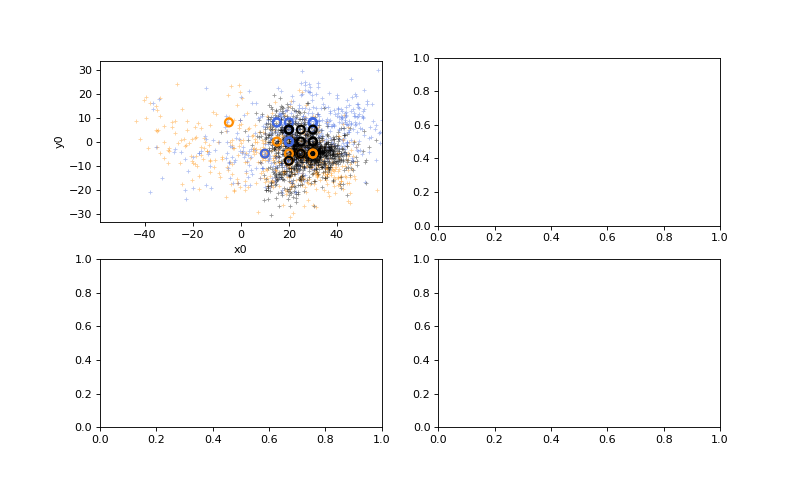

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]